In [1]:
# CIFAR-10 CNN Model Evaluation
# This notebook loads a pre-trained CNN model with provided weights
# and evaluates it on the first 1,000 validation images of CIFAR-10

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import time
import os

In [2]:
NUMBER_OF_TEST_IMAGES = 1000

In [3]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Create the model as specified
inputs = Input(shape=(32, 32, 3), name='input_layer')
# Convert RGB to grayscale
x = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True), name='lambda')(inputs)
# First Conv layer
x = Conv2D(4, (3, 3), activation='relu', padding='same', name='conv2d')(x)
x = MaxPooling2D((2, 2), name='max_pooling2d')(x)
# Second Conv layer
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='conv2d_1')(x)
x = MaxPooling2D((2, 2), name='max_pooling2d_1')(x)
# Flatten and classify
x = Flatten(name='flatten')(x)
outputs = Dense(10, activation='softmax', name='dense')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Upload the .h5 file to Colab
from google.colab import files
print("Please upload the cifar10_cnn.weights.h5 file:")
uploaded = files.upload()

# Load the weights
model.load_weights('cifar10_cnn.weights.h5')

# Display model summary
model.summary()

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Please upload the cifar10_cnn.weights.h5 file:


Saving cifar10_cnn.weights.h5 to cifar10_cnn.weights.h5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 4)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,466 (21.35 KB)

 Trainable params: 5,466 (21.35 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Initialize variables for evaluation
correct_predictions = 0
inference_times = []
output_text = []

# Evaluate on the first 1000 validation images
for i in range(NUMBER_OF_TEST_IMAGES):
    # Get the image and true label
    image = x_test[i:i+1]  # Keep batch dimension
    true_label = y_test[i][0]  # Get the scalar label

    # Calculate average RGB values for the image
    original_image = x_test[i] * 255.0  # Convert back to 0-255 range
    avg_r = int(np.mean(original_image[:,:,0]))
    avg_g = int(np.mean(original_image[:,:,1]))
    avg_b = int(np.mean(original_image[:,:,2]))

    # Measure inference time
    start_time = time.time()
    prediction = model.predict(image, verbose=0)
    end_time = time.time()

    # Calculate inference time in milliseconds
    inference_time = (end_time - start_time) * 1000
    inference_times.append(inference_time)

    # Get the predicted class and confidence
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class] * 100

    # Check if the prediction is correct
    is_correct = (predicted_class == true_label)
    if is_correct:
        correct_predictions += 1

    # Format the output line
    output_line = [
        f"Image #{i} (Batch 1): Label={true_label}, Avg RGB=({avg_r},{avg_g},{avg_b})",
        f"The model predicts to be label {predicted_class} with confidence {confidence:.2f}% and inference time {inference_time:.0f} ms",
        "TRUE" if is_correct else "FALSE"
    ]
    output_text.extend(output_line)

# Calculate final statistics
accuracy = (correct_predictions / NUMBER_OF_TEST_IMAGES) * 100
avg_inference_time = np.mean(inference_times)
total_inference_time = np.sum(inference_times) / 1000  # Convert to seconds

# Add summary to output
output_text.append(f"FINISHED FIRST {NUMBER_OF_TEST_IMAGES} IMAGES!")
output_text.append(f"- Accuracy after running {NUMBER_OF_TEST_IMAGES} first images: {accuracy:.2f}%")
output_text.append(f"- Average inference time after running {NUMBER_OF_TEST_IMAGES} first images: {avg_inference_time:.2f} ms")
output_text.append(f"- Total inference time after running {NUMBER_OF_TEST_IMAGES} first images: {total_inference_time:.2f} (s)")

# Write to file
with open('google_colab_predictions.txt', 'w') as f:
    f.write('\n'.join(output_text))

# Download the predictions file
files.download('google_colab_predictions.txt')

print(f"Evaluation completed with {accuracy:.2f}% accuracy")
print(f"Average inference time: {avg_inference_time:.2f} ms")
print(f"Total inference time: {total_inference_time:.2f} seconds")
print("Results saved to google_colab_predictions.txt and downloaded")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Evaluation completed with 59.90% accuracy
Average inference time: 98.13 ms
Total inference time: 98.13 seconds
Results saved to google_colab_predictions.txt and downloaded


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


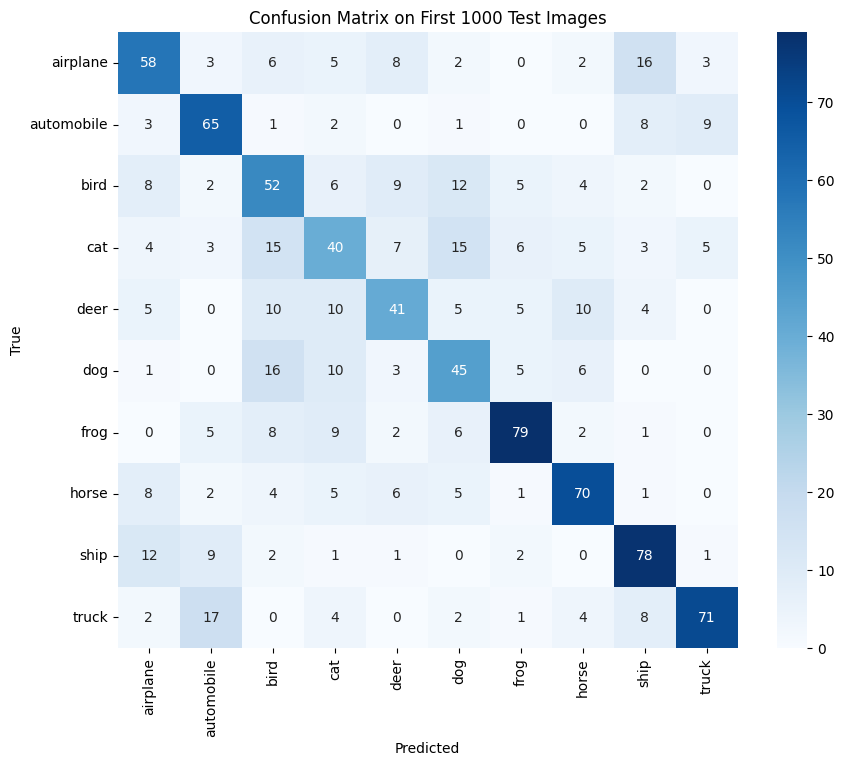

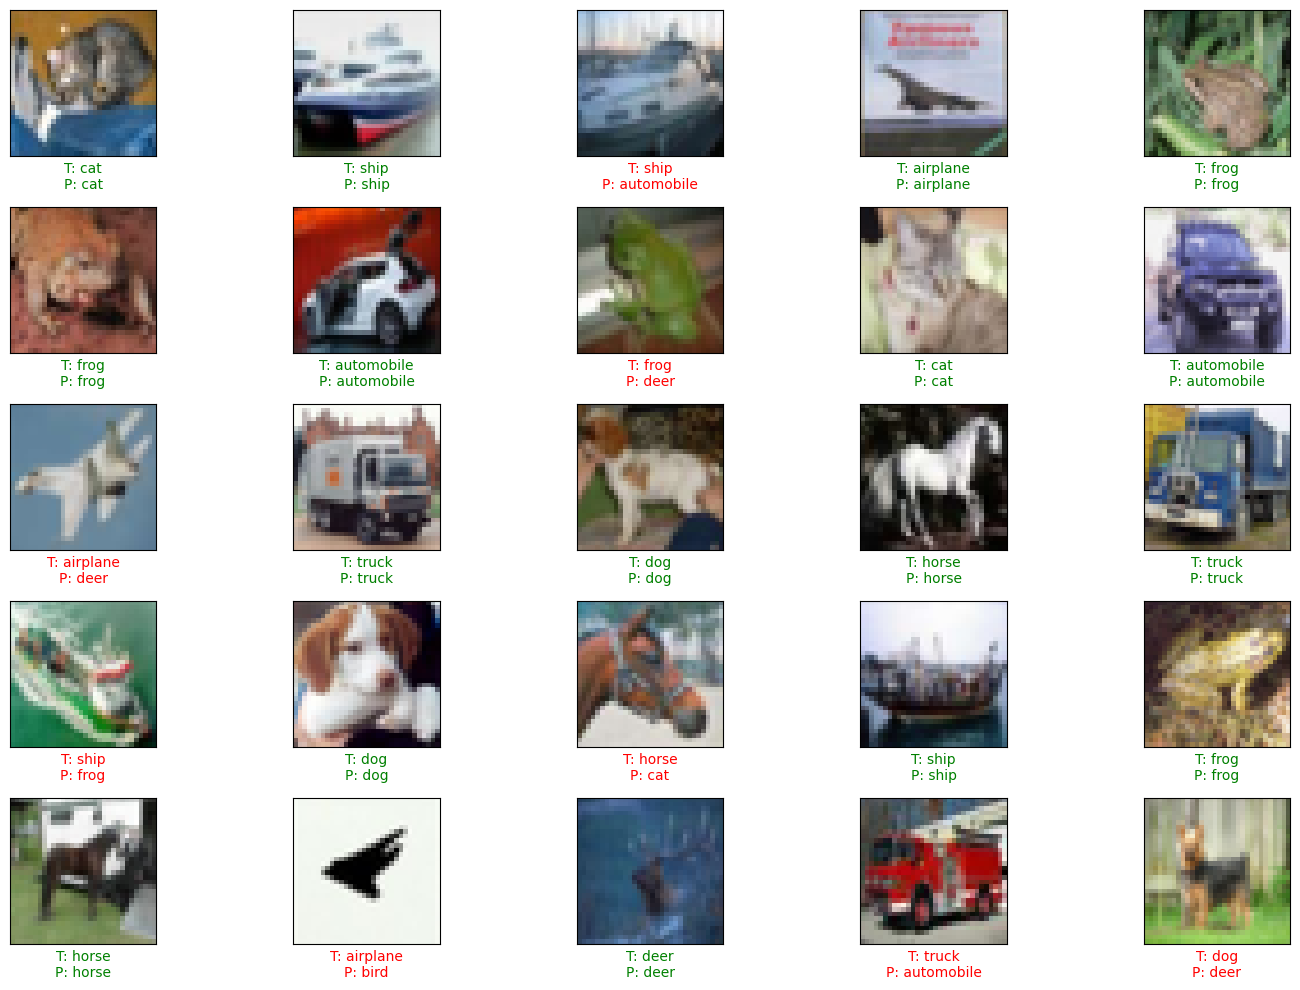

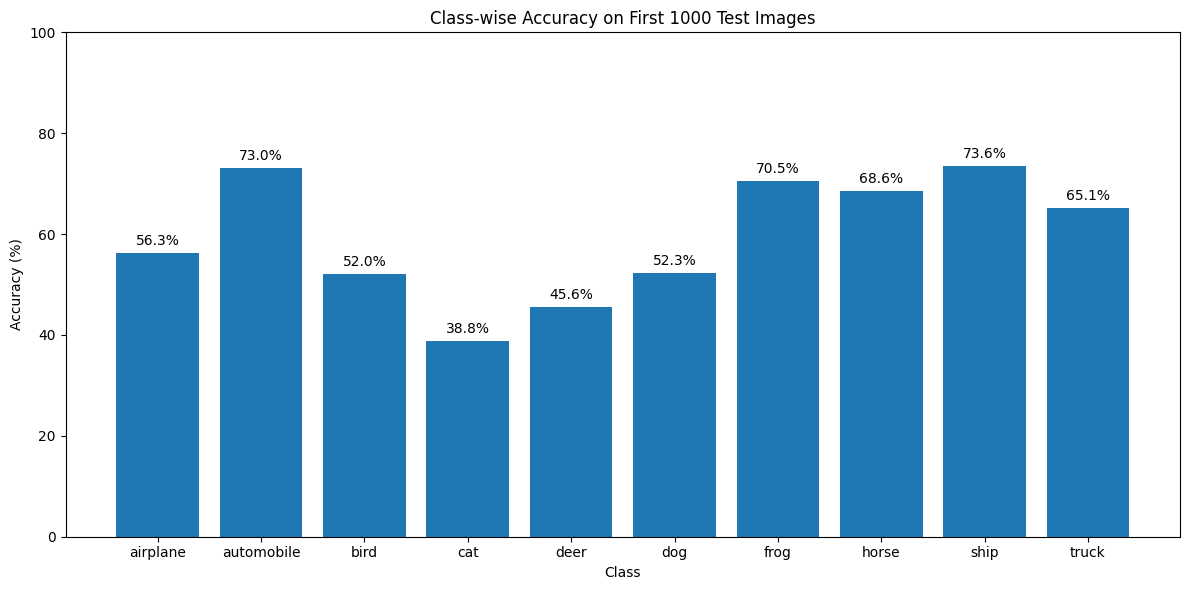

In [6]:
# Display confusion matrix for the first 1000 samples
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get all predictions for the confusion matrix
all_predictions = model.predict(x_test[:NUMBER_OF_TEST_IMAGES], verbose=1)
predicted_classes = np.argmax(all_predictions, axis=1)
true_classes = y_test[:NUMBER_OF_TEST_IMAGES].squeeze()

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix on First {NUMBER_OF_TEST_IMAGES} Test Images')
plt.show()

# Visualize some example predictions
plt.figure(figsize=(15, 10))
for i in range(25):  # Show the first 25 images
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i])

    predicted_label = predicted_classes[i]
    true_label = true_classes[i]

    color = 'green' if predicted_label == true_label else 'red'

    plt.xlabel(f"T: {class_names[true_label]}\nP: {class_names[predicted_label]}", color=color)

plt.tight_layout()
plt.show()

# Calculate and display class-wise accuracy
class_accuracies = {}
for i in range(10):
    class_mask = (true_classes == i)
    if np.sum(class_mask) > 0:  # Ensure there are samples for this class
        class_acc = np.mean(predicted_classes[class_mask] == true_classes[class_mask])
        class_accuracies[class_names[i]] = class_acc * 100

# Plot class-wise accuracy
plt.figure(figsize=(12, 6))
classes = list(class_accuracies.keys())
accs = list(class_accuracies.values())
bars = plt.bar(classes, accs)
plt.ylim(0, 100)
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title(f'Class-wise Accuracy on First {NUMBER_OF_TEST_IMAGES} Test Images')

# Add accuracy values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.show()

ML Model Comparison: Google Colab vs STM32
1. Run single analysis
2. Run multiple analyses (batch mode)
3. Quick comparison of all FP ABI and optimization combinations

Select an option (1-3): 2
Batch mode: You'll be able to upload multiple STM32 files and analyze them.
Successfully loaded google_colab_predictions.txt
Please upload the STM32 predictions file:


Saving stm32_soft_O0_predictions.txt to stm32_soft_O0_predictions (1).txt
Successfully uploaded stm32_soft_O0_predictions (1).txt

Select FP ABI setting:
1. soft
2. softfp
3. hard
Enter choice (1-3): 1

Select compiler optimization:
1. O0
2. O1
3. O2
4. O3
5. Ofast
6. Og
7. Os
8. Oz
Enter choice (1-8): 1

Using FP ABI: soft, Optimization: O0

STM32 file options:
1. stm32_soft_O0_predictions (1).txt
2. Upload a new STM32 file
Select file (1-2): 1
Using cached file: stm32_soft_O0_predictions (1).txt

Analyzing performance for stm32_soft_O0_predictions (1).txt_soft_O0...

====== COMPARISON RESULTS ======
STM32 Configuration: FP ABI = soft, Optimization = O0
Google Colab Accuracy: 59.90%
STM32 Accuracy: 59.90%
Accuracy Difference: 0.00%
Number of different predictions: 0 out of 1000
Number of cases where one model is correct and the other is wrong: 0
Average confidence difference: 0.00%
Standard deviation of confidence differences: 0.00%
Median confidence difference: 0.00%
25th percentile 

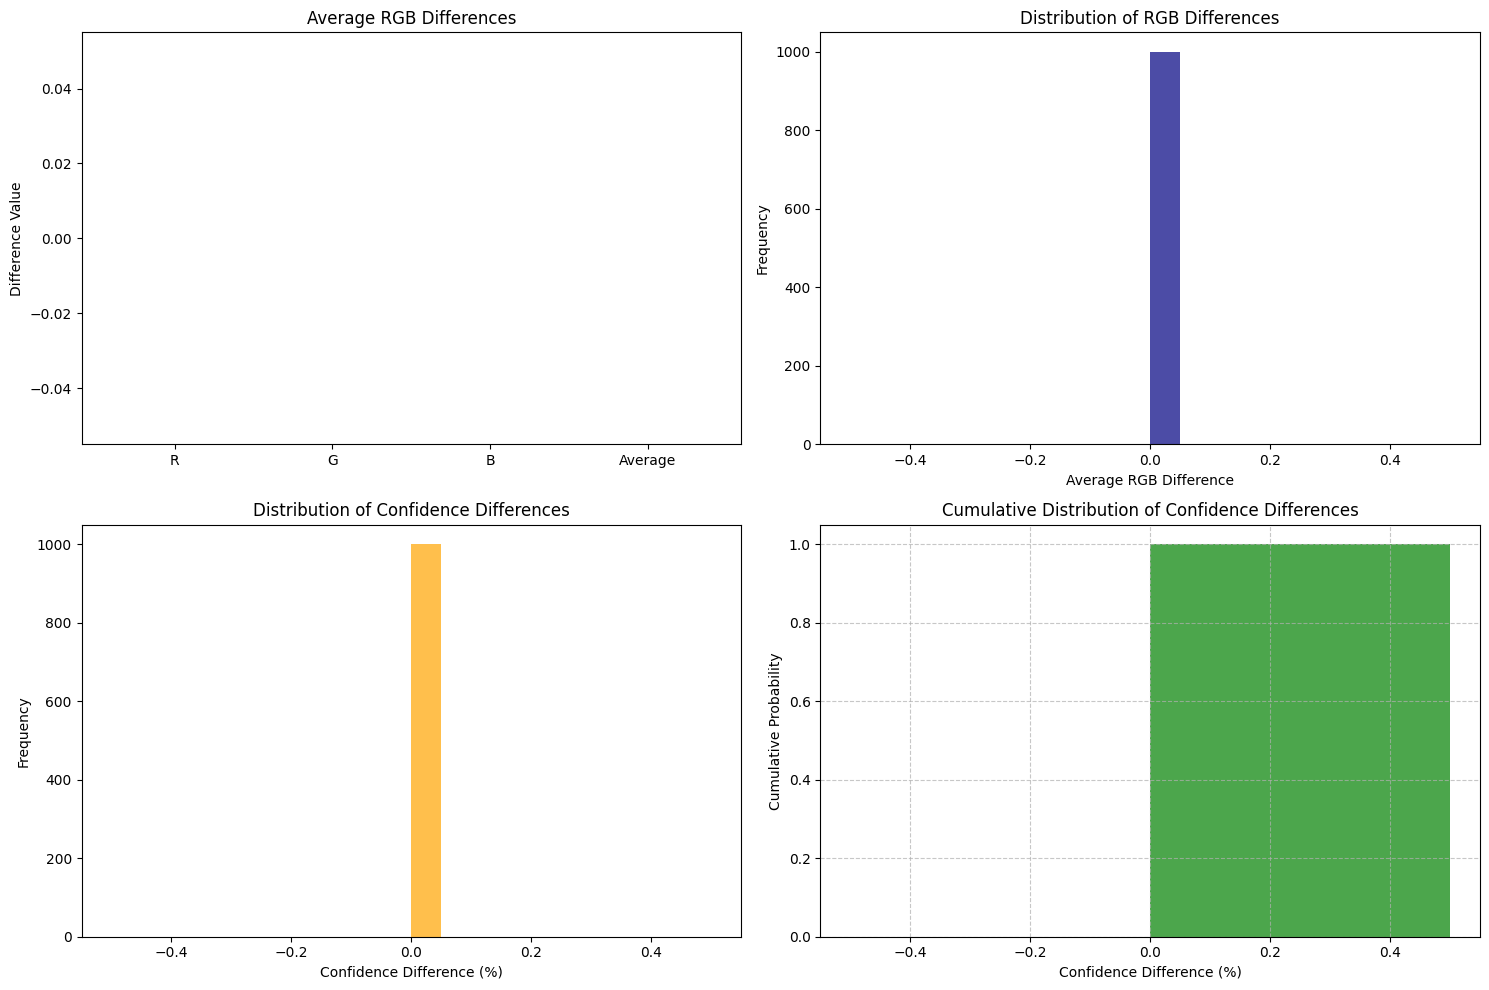

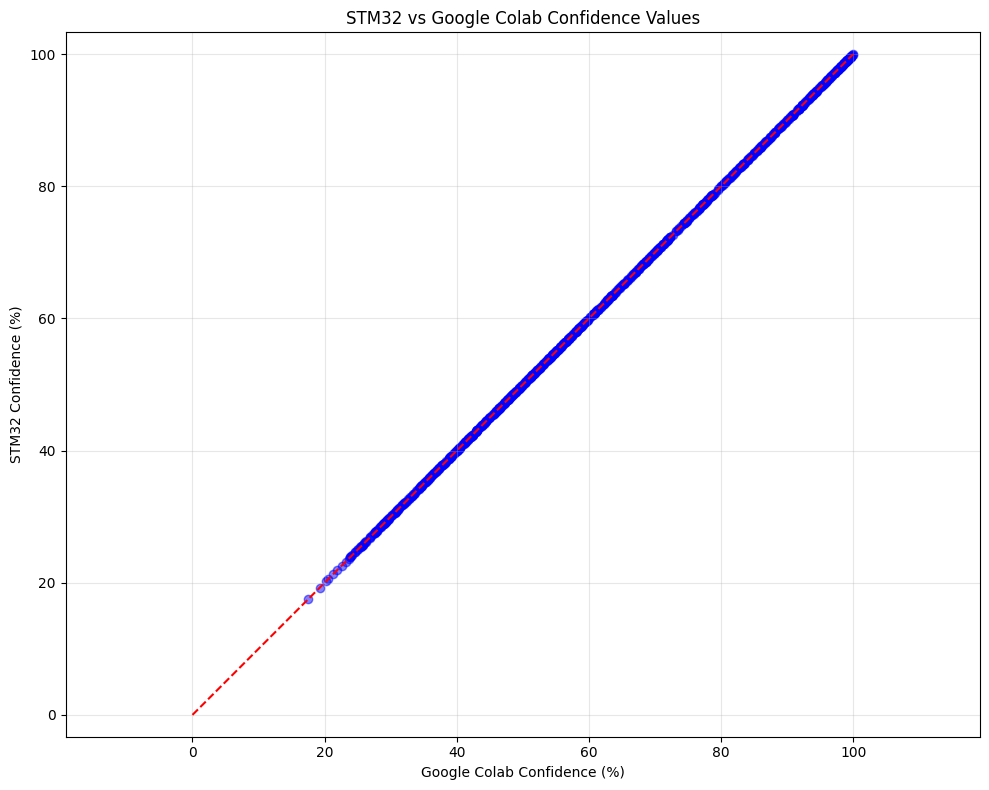

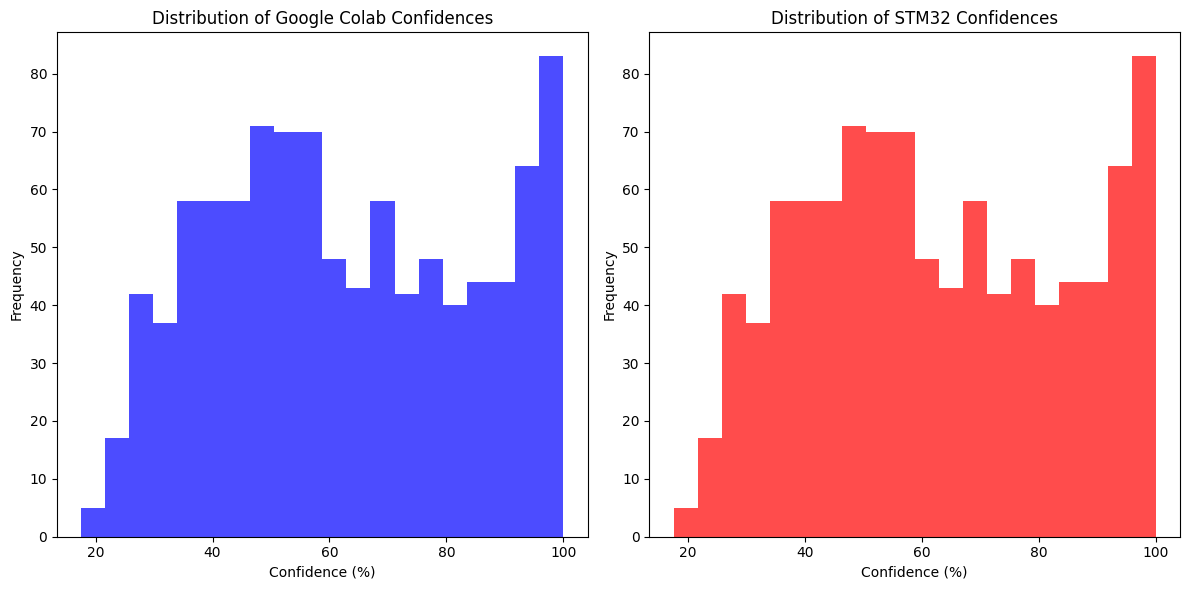

Results saved to comparison_results_soft_O0.txt

Run another analysis?
1. Yes
2. No
Enter choice (1-2): 1

Select FP ABI setting:
1. soft
2. softfp
3. hard
Enter choice (1-3): 2

Select compiler optimization:
1. O0
2. O1
3. O2
4. O3
5. Ofast
6. Og
7. Os
8. Oz
Enter choice (1-8): 1

Using FP ABI: softfp, Optimization: O0

STM32 file options:
1. stm32_soft_O0_predictions (1).txt
2. Upload a new STM32 file
Select file (1-2): 2
Upload a new STM32 predictions file:


Saving stm32_softfp_O0_predictions.txt to stm32_softfp_O0_predictions.txt
Added new file: stm32_softfp_O0_predictions.txt

Analyzing performance for stm32_softfp_O0_predictions.txt_softfp_O0...

====== COMPARISON RESULTS ======
STM32 Configuration: FP ABI = softfp, Optimization = O0
Google Colab Accuracy: 59.90%
STM32 Accuracy: 59.90%
Accuracy Difference: 0.00%
Number of different predictions: 0 out of 1000
Number of cases where one model is correct and the other is wrong: 0
Average confidence difference: 0.00%
Standard deviation of confidence differences: 0.00%
Median confidence difference: 0.00%
25th percentile of confidence differences: 0.00%
75th percentile of confidence differences: 0.00%
Maximum confidence difference: 0.00% (Image #0)

====== RGB DIFFERENCE RESULTS ======
Average R difference: 0.00
Average G difference: 0.00
Average B difference: 0.00
Average RGB difference: 0.00

====== DETAILED COMPARISON (First 10 Images) ======
Image # | True Label | Colab Prediction | Colab 

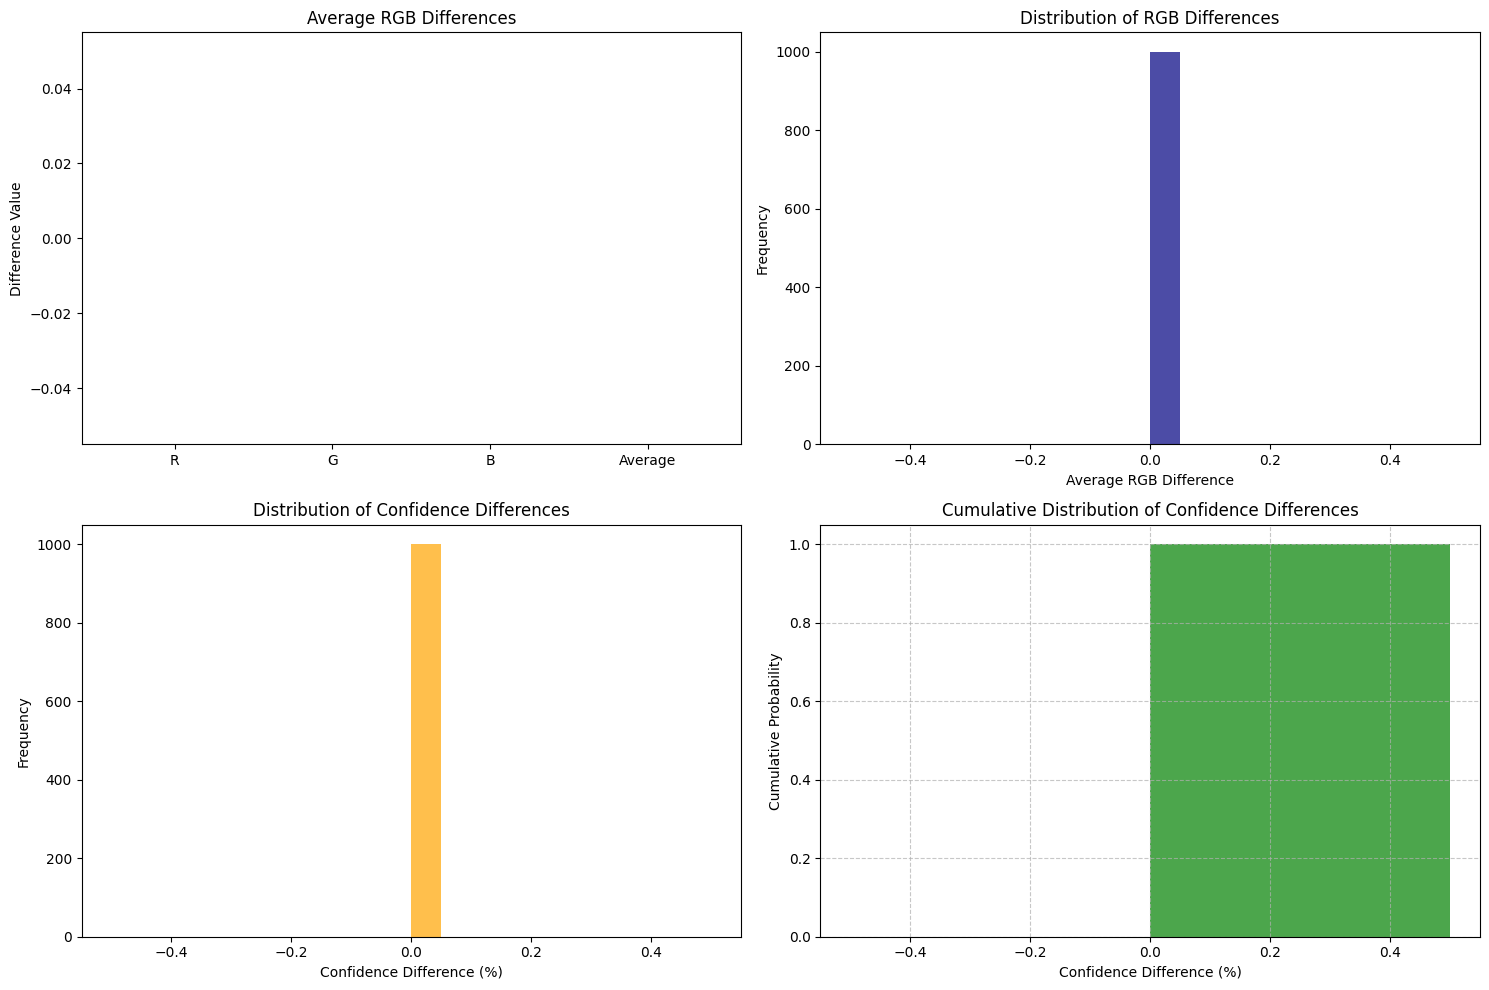

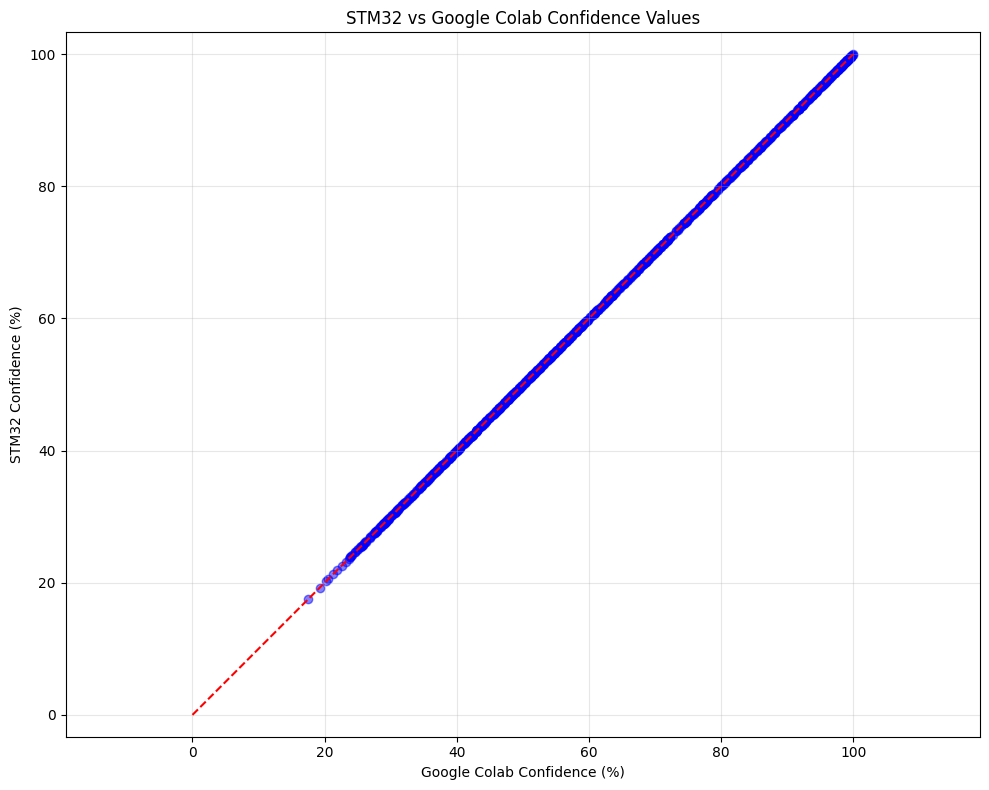

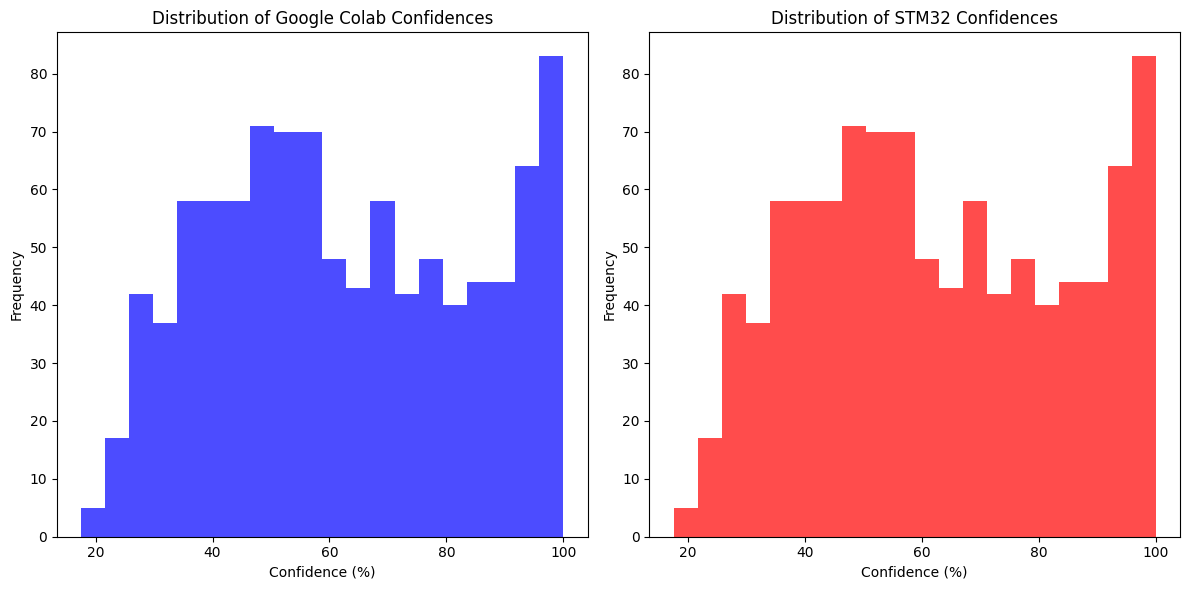

Results saved to comparison_results_softfp_O0.txt

====== CONFIGURATION COMPARISON ======
Configuration | STM32 Accuracy | Accuracy Diff | Prediction Diffs | Avg Confidence Diff
-------------|----------------|---------------|------------------|-------------------
soft_O0       |          59.90% |          0.00% |                  0 |                0.00%
softfp_O0     |          59.90% |          0.00% |                  0 |                0.00%


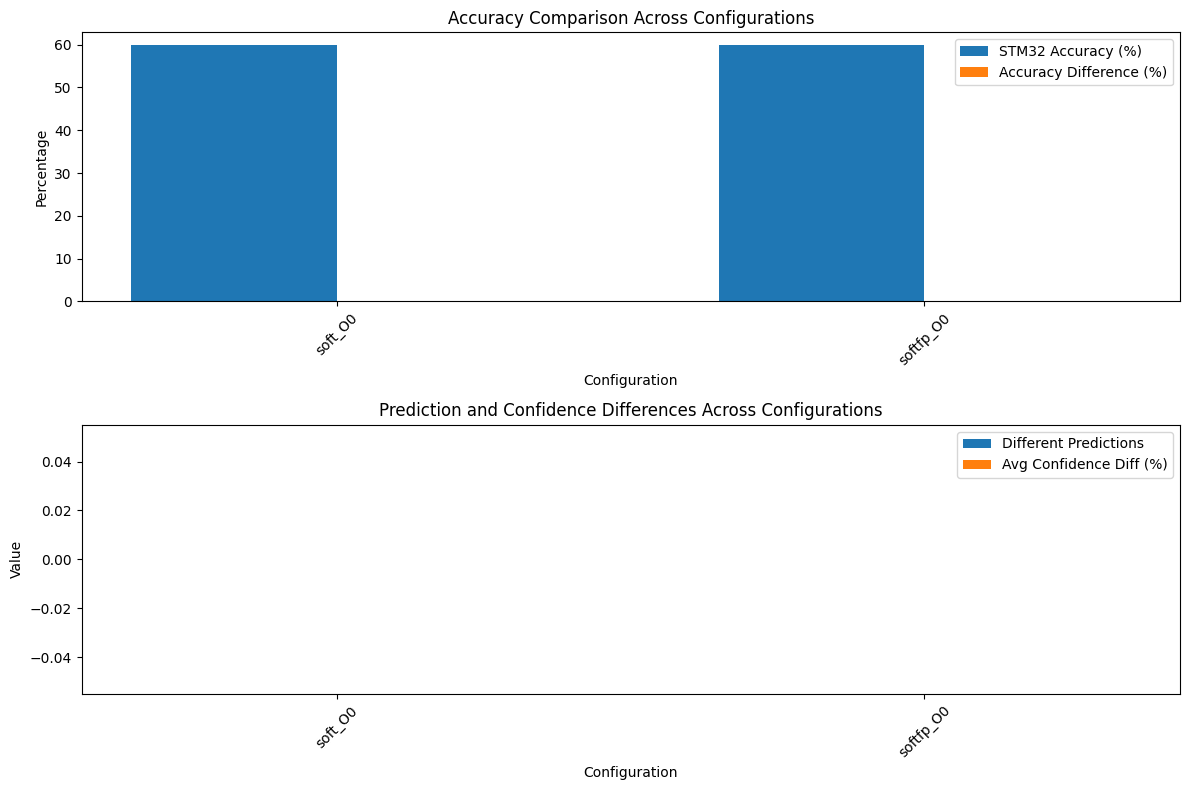


Run another analysis?
1. Yes
2. No
Enter choice (1-2): 1

Select FP ABI setting:
1. soft
2. softfp
3. hard
Enter choice (1-3): 3

Select compiler optimization:
1. O0
2. O1
3. O2
4. O3
5. Ofast
6. Og
7. Os
8. Oz
Enter choice (1-8): 1

Using FP ABI: hard, Optimization: O0

STM32 file options:
1. stm32_soft_O0_predictions (1).txt
2. stm32_softfp_O0_predictions.txt
3. Upload a new STM32 file
Select file (1-3): 3
Upload a new STM32 predictions file:


Saving stm32_hard_O0_predictions.txt to stm32_hard_O0_predictions.txt
Added new file: stm32_hard_O0_predictions.txt

Analyzing performance for stm32_hard_O0_predictions.txt_hard_O0...

====== COMPARISON RESULTS ======
STM32 Configuration: FP ABI = hard, Optimization = O0
Google Colab Accuracy: 59.90%
STM32 Accuracy: 59.90%
Accuracy Difference: 0.00%
Number of different predictions: 0 out of 1000
Number of cases where one model is correct and the other is wrong: 0
Average confidence difference: 0.00%
Standard deviation of confidence differences: 0.00%
Median confidence difference: 0.00%
25th percentile of confidence differences: 0.00%
75th percentile of confidence differences: 0.00%
Maximum confidence difference: 0.00% (Image #0)

====== RGB DIFFERENCE RESULTS ======
Average R difference: 0.00
Average G difference: 0.00
Average B difference: 0.00
Average RGB difference: 0.00

====== DETAILED COMPARISON (First 10 Images) ======
Image # | True Label | Colab Prediction | Colab Confidence |

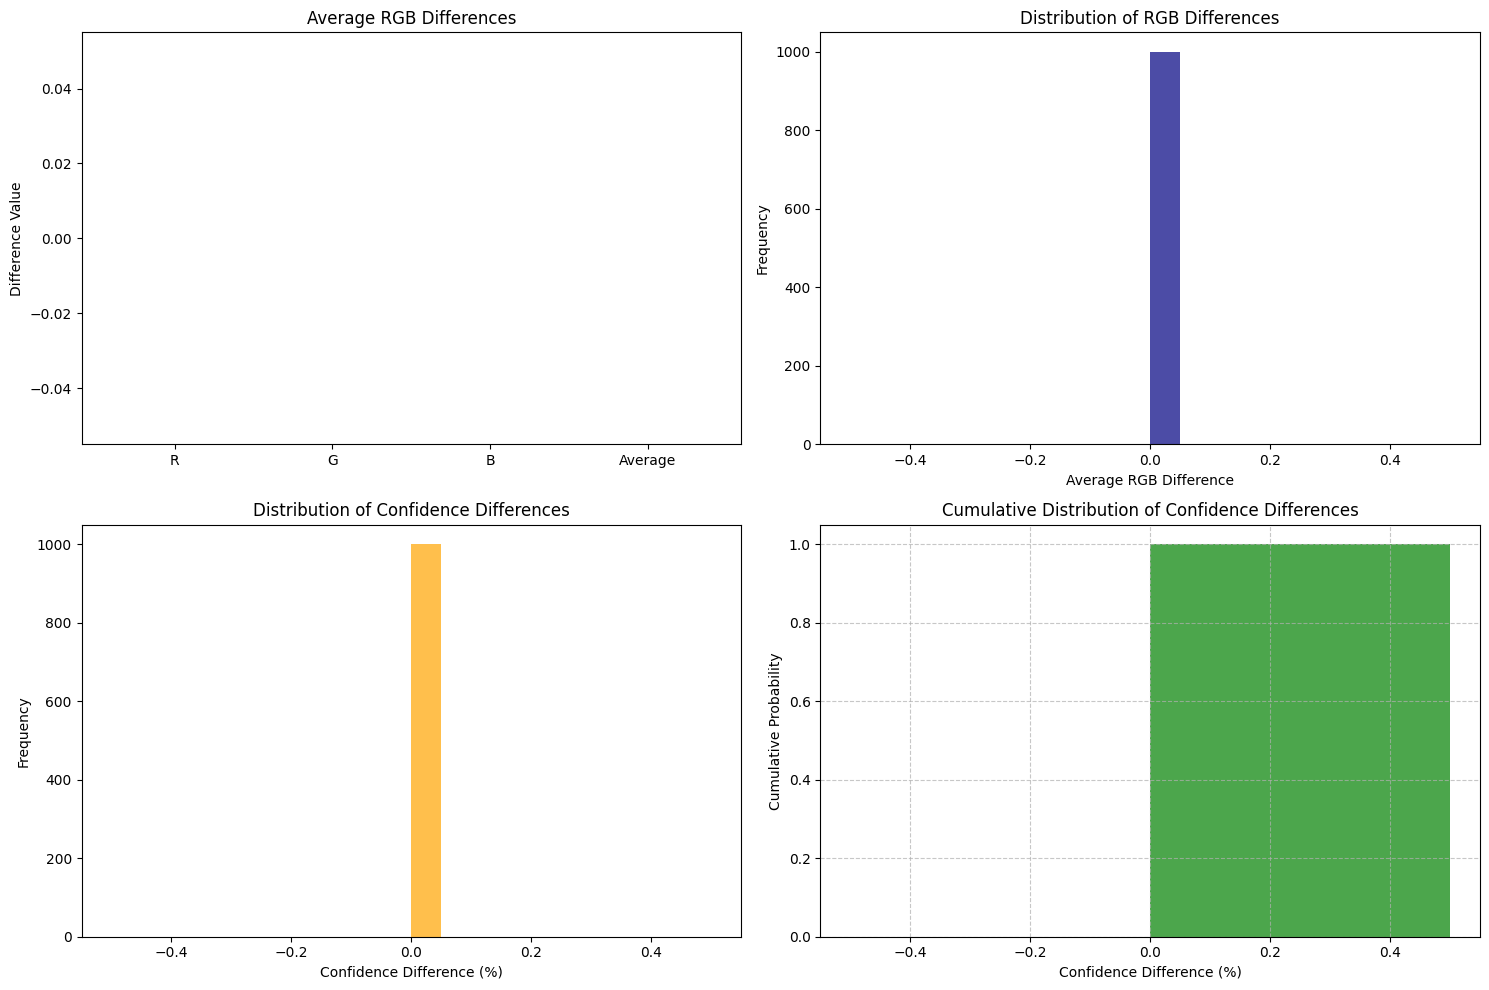

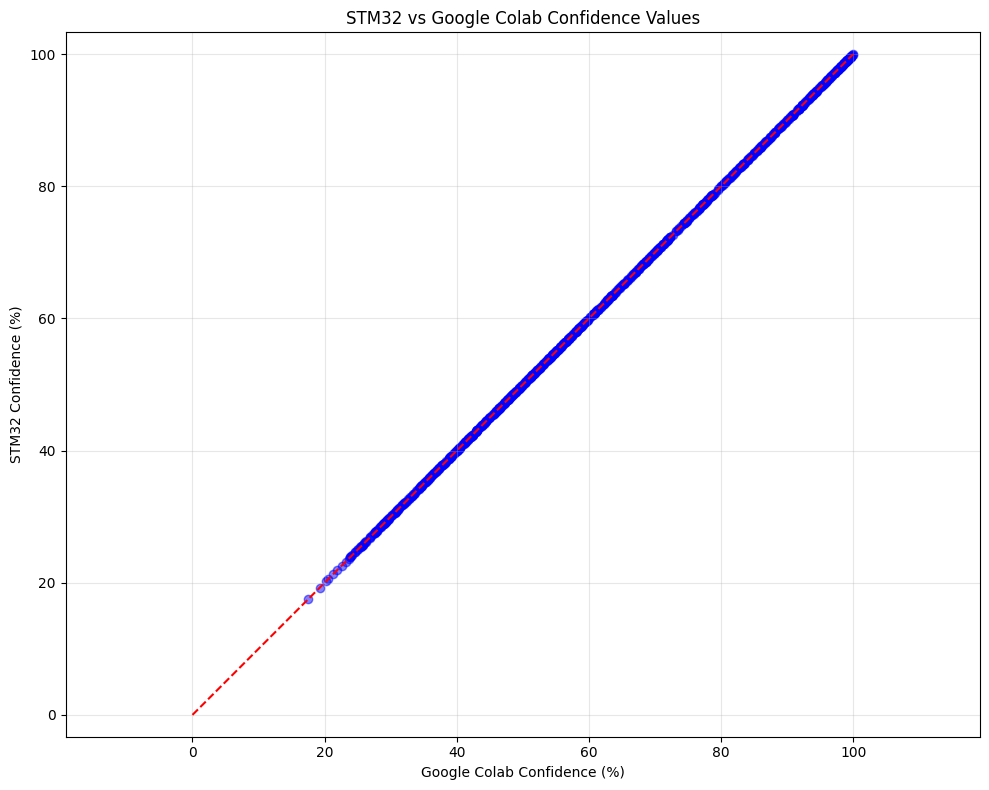

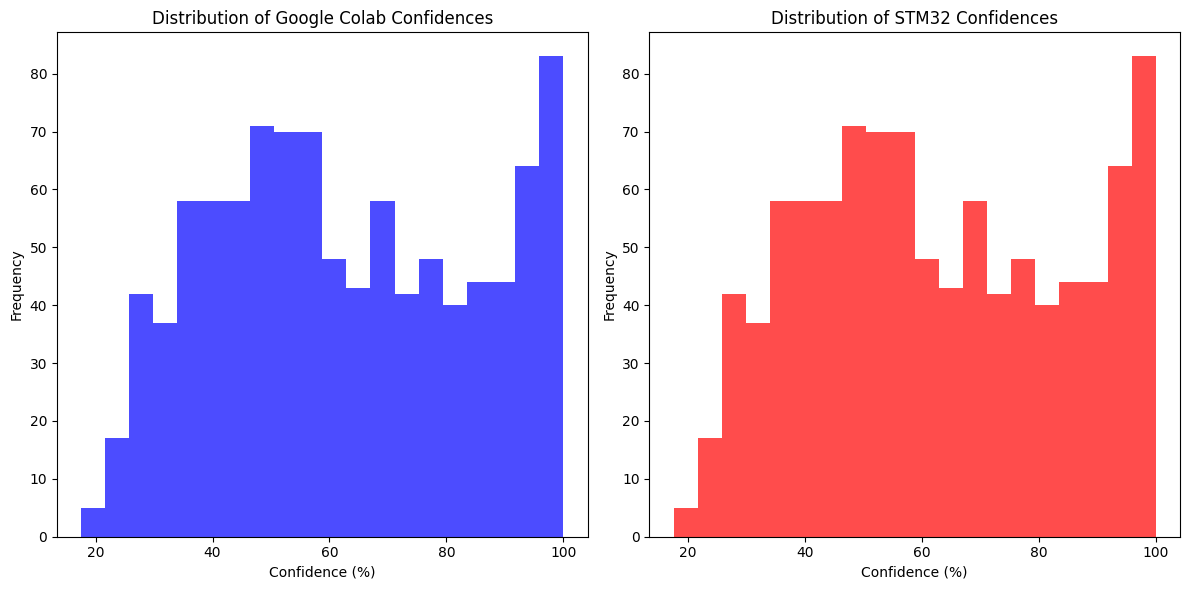

Results saved to comparison_results_hard_O0.txt

====== CONFIGURATION COMPARISON ======
Configuration | STM32 Accuracy | Accuracy Diff | Prediction Diffs | Avg Confidence Diff
-------------|----------------|---------------|------------------|-------------------
soft_O0       |          59.90% |          0.00% |                  0 |                0.00%
softfp_O0     |          59.90% |          0.00% |                  0 |                0.00%
hard_O0       |          59.90% |          0.00% |                  0 |                0.00%


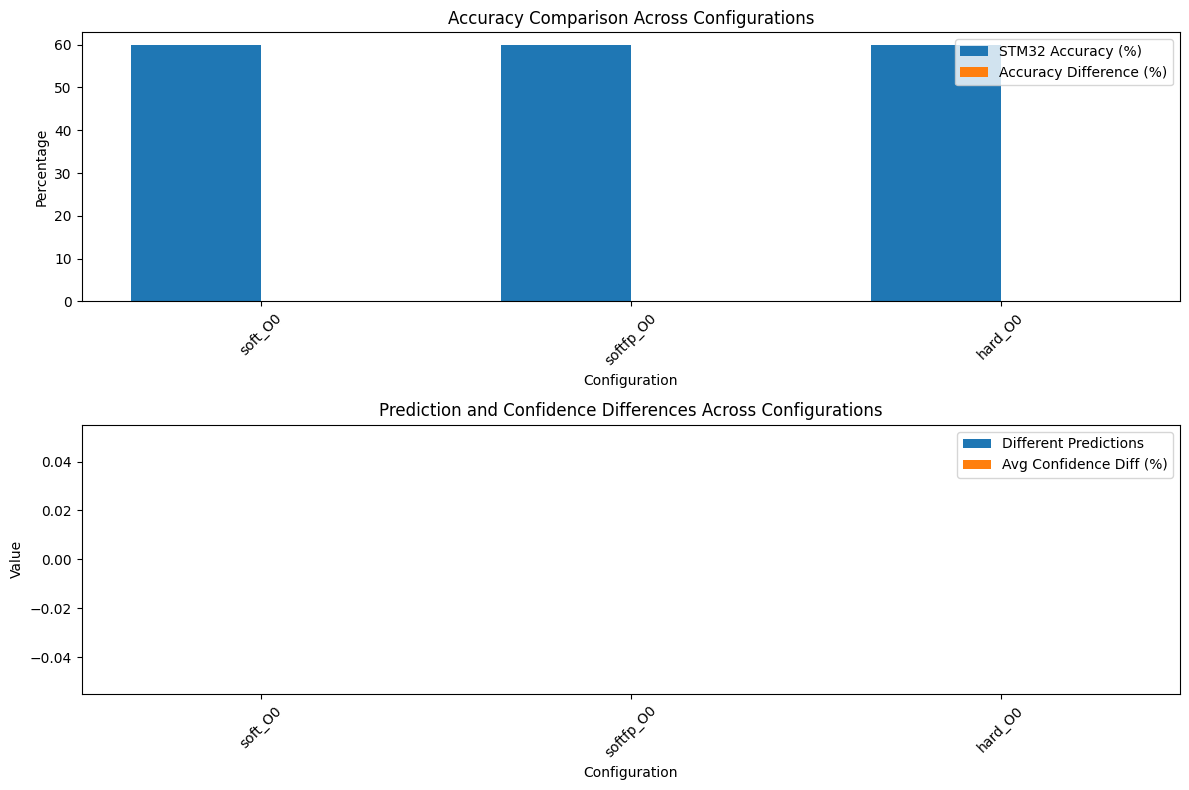


Run another analysis?
1. Yes
2. No
Enter choice (1-2): 1

Select FP ABI setting:
1. soft
2. softfp
3. hard
Enter choice (1-3): 3

Select compiler optimization:
1. O0
2. O1
3. O2
4. O3
5. Ofast
6. Og
7. Os
8. Oz
Enter choice (1-8): 2

Using FP ABI: hard, Optimization: O1

STM32 file options:
1. stm32_soft_O0_predictions (1).txt
2. stm32_softfp_O0_predictions.txt
3. stm32_hard_O0_predictions.txt
4. Upload a new STM32 file
Select file (1-4): 4
Upload a new STM32 predictions file:


Saving stm32_hard_O1_predictions.txt to stm32_hard_O1_predictions.txt
Added new file: stm32_hard_O1_predictions.txt

Analyzing performance for stm32_hard_O1_predictions.txt_hard_O1...

====== COMPARISON RESULTS ======
STM32 Configuration: FP ABI = hard, Optimization = O1
Google Colab Accuracy: 59.90%
STM32 Accuracy: 59.90%
Accuracy Difference: 0.00%
Number of different predictions: 0 out of 1000
Number of cases where one model is correct and the other is wrong: 0
Average confidence difference: 0.00%
Standard deviation of confidence differences: 0.00%
Median confidence difference: 0.00%
25th percentile of confidence differences: 0.00%
75th percentile of confidence differences: 0.00%
Maximum confidence difference: 0.00% (Image #0)

====== RGB DIFFERENCE RESULTS ======
Average R difference: 0.00
Average G difference: 0.00
Average B difference: 0.00
Average RGB difference: 0.00

====== DETAILED COMPARISON (First 10 Images) ======
Image # | True Label | Colab Prediction | Colab Confidence |

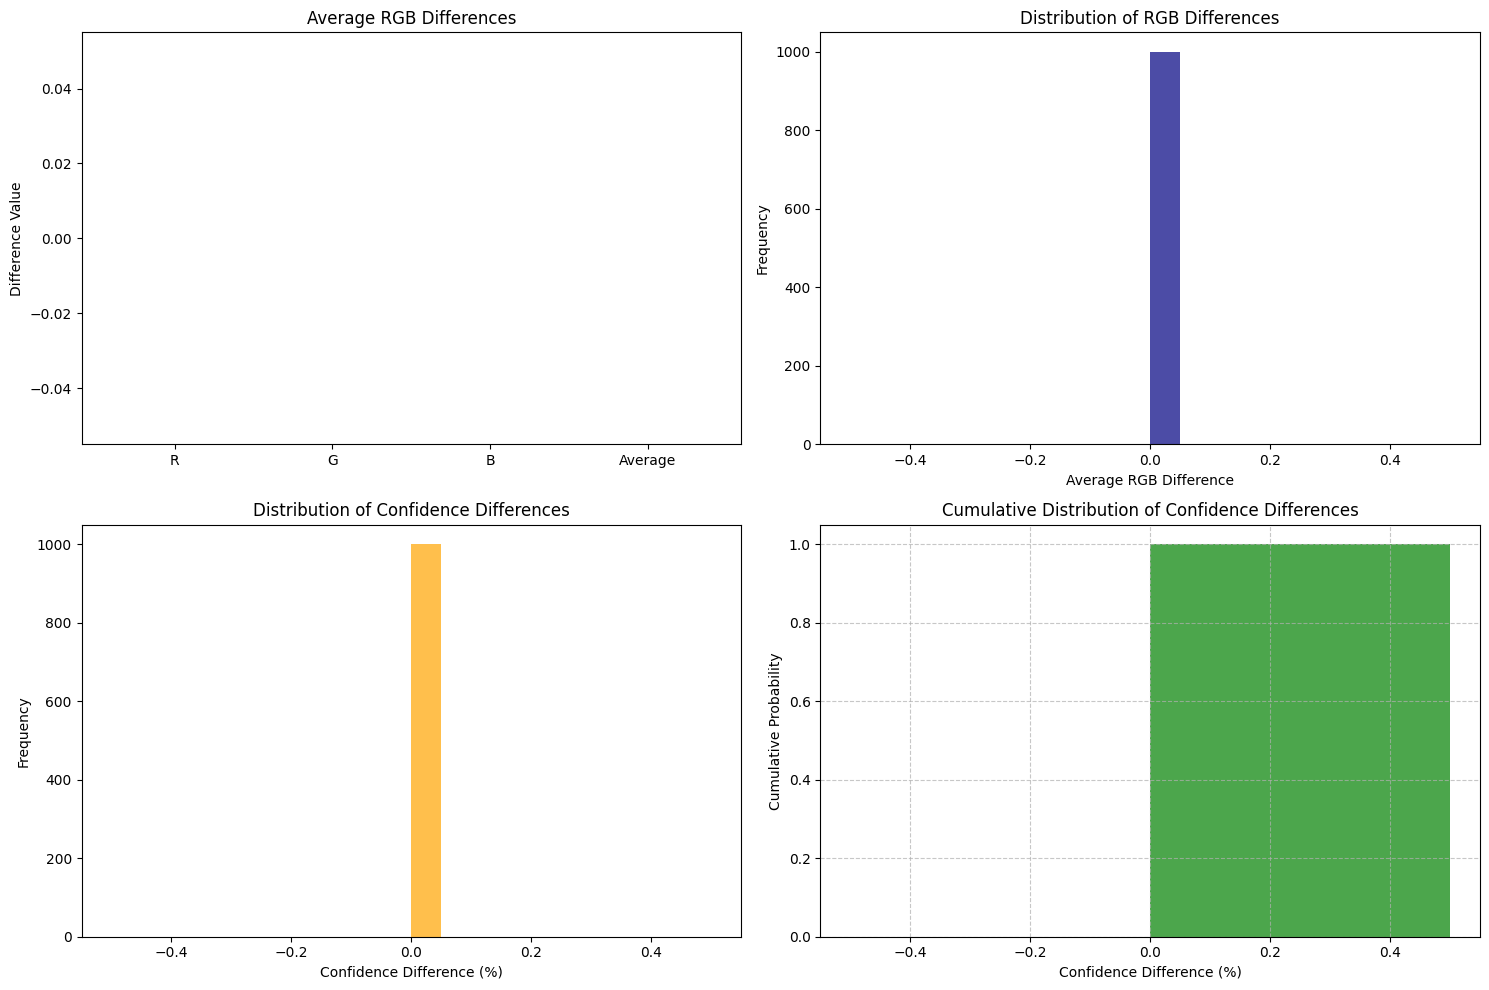

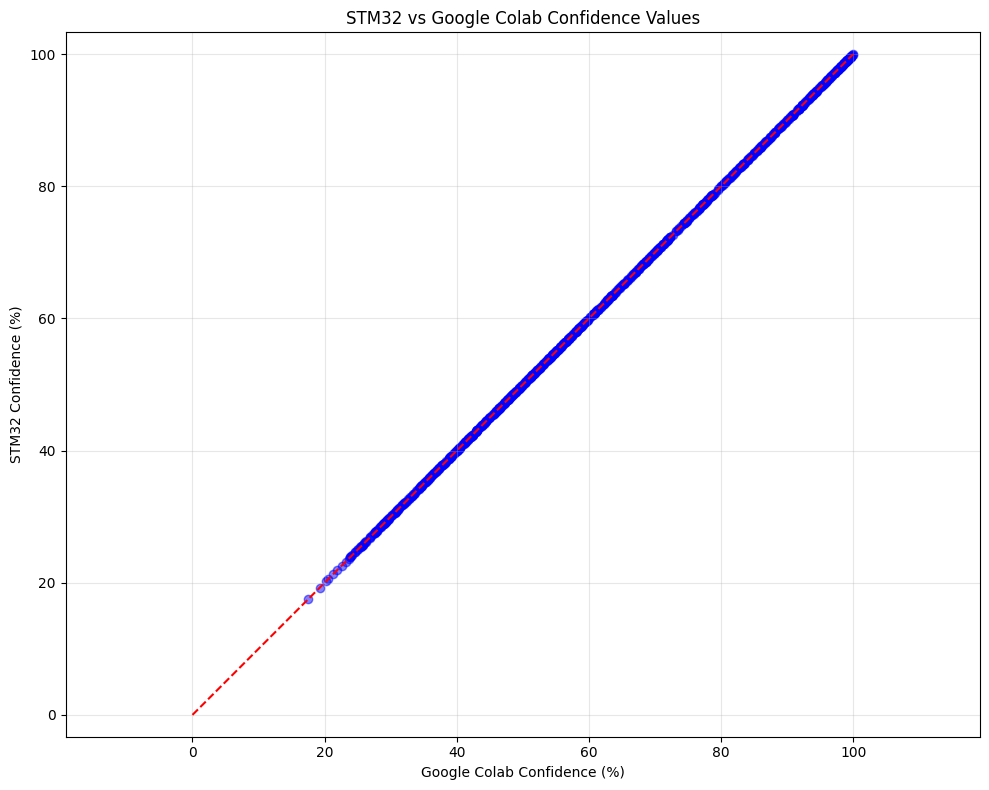

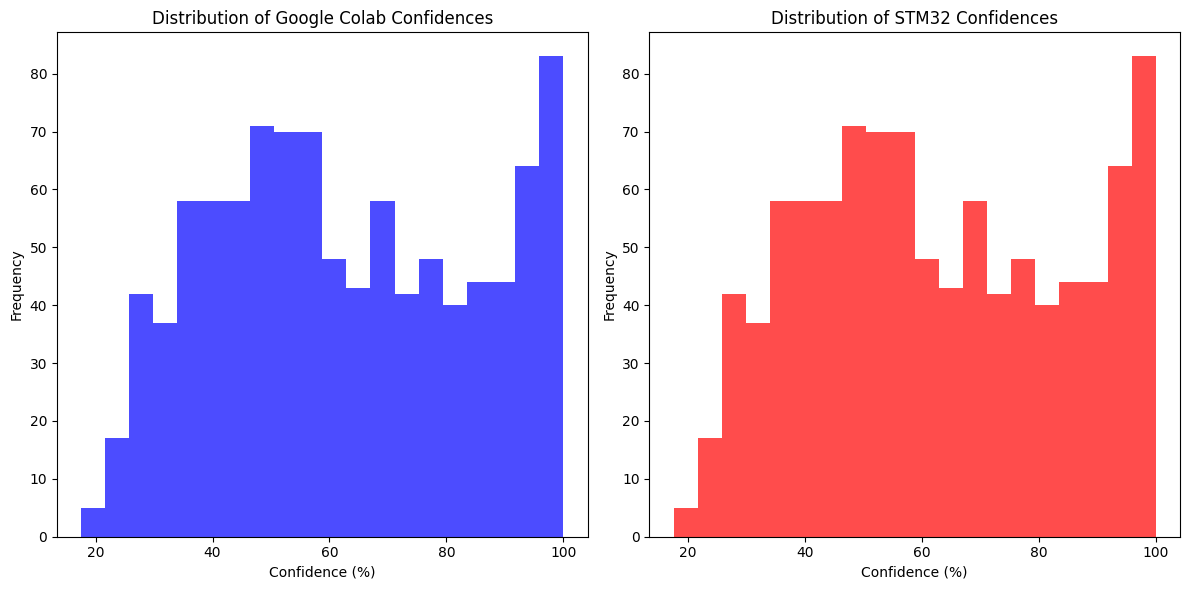

Results saved to comparison_results_hard_O1.txt

====== CONFIGURATION COMPARISON ======
Configuration | STM32 Accuracy | Accuracy Diff | Prediction Diffs | Avg Confidence Diff
-------------|----------------|---------------|------------------|-------------------
soft_O0       |          59.90% |          0.00% |                  0 |                0.00%
softfp_O0     |          59.90% |          0.00% |                  0 |                0.00%
hard_O0       |          59.90% |          0.00% |                  0 |                0.00%
hard_O1       |          59.90% |          0.00% |                  0 |                0.00%


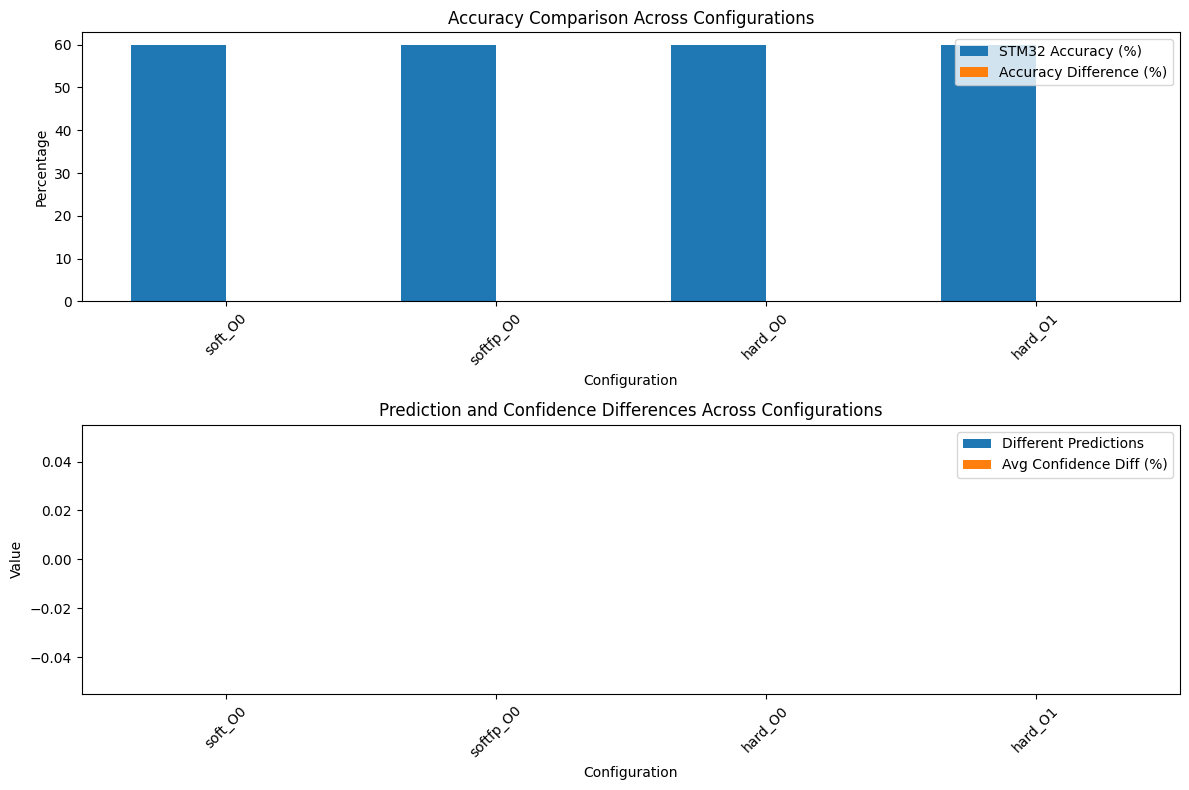


Run another analysis?
1. Yes
2. No
Enter choice (1-2): 1

Select FP ABI setting:
1. soft
2. softfp
3. hard
Enter choice (1-3): 3

Select compiler optimization:
1. O0
2. O1
3. O2
4. O3
5. Ofast
6. Og
7. Os
8. Oz
Enter choice (1-8): 3

Using FP ABI: hard, Optimization: O2

STM32 file options:
1. stm32_soft_O0_predictions (1).txt
2. stm32_softfp_O0_predictions.txt
3. stm32_hard_O0_predictions.txt
4. stm32_hard_O1_predictions.txt
5. Upload a new STM32 file
Select file (1-5): 5
Upload a new STM32 predictions file:


Saving stm32_hard_O2_predictions.txt to stm32_hard_O2_predictions.txt
Added new file: stm32_hard_O2_predictions.txt

Analyzing performance for stm32_hard_O2_predictions.txt_hard_O2...

====== COMPARISON RESULTS ======
STM32 Configuration: FP ABI = hard, Optimization = O2
Google Colab Accuracy: 59.90%
STM32 Accuracy: 59.90%
Accuracy Difference: 0.00%
Number of different predictions: 0 out of 1000
Number of cases where one model is correct and the other is wrong: 0
Average confidence difference: 0.00%
Standard deviation of confidence differences: 0.00%
Median confidence difference: 0.00%
25th percentile of confidence differences: 0.00%
75th percentile of confidence differences: 0.00%
Maximum confidence difference: 0.00% (Image #0)

====== RGB DIFFERENCE RESULTS ======
Average R difference: 0.00
Average G difference: 0.00
Average B difference: 0.00
Average RGB difference: 0.00

====== DETAILED COMPARISON (First 10 Images) ======
Image # | True Label | Colab Prediction | Colab Confidence |

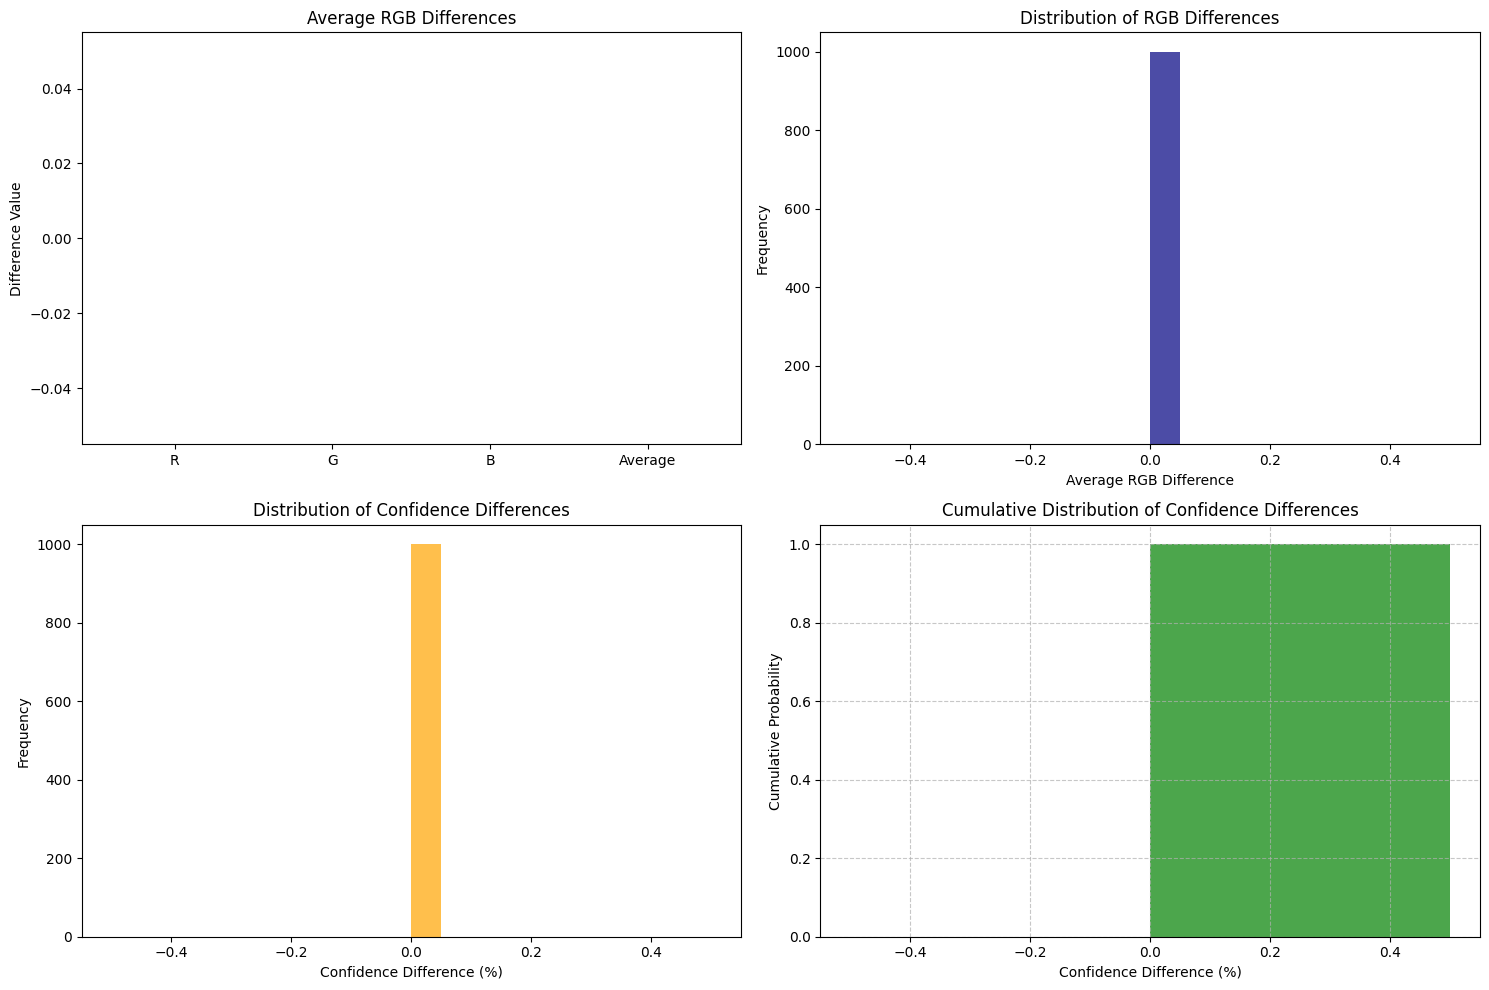

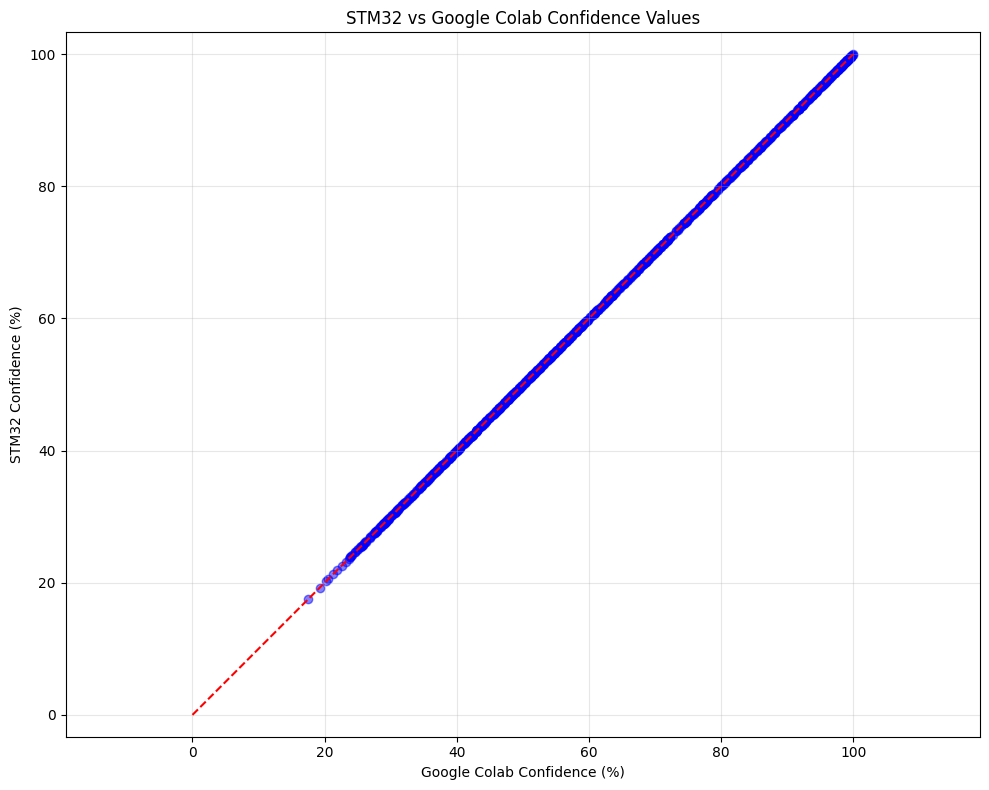

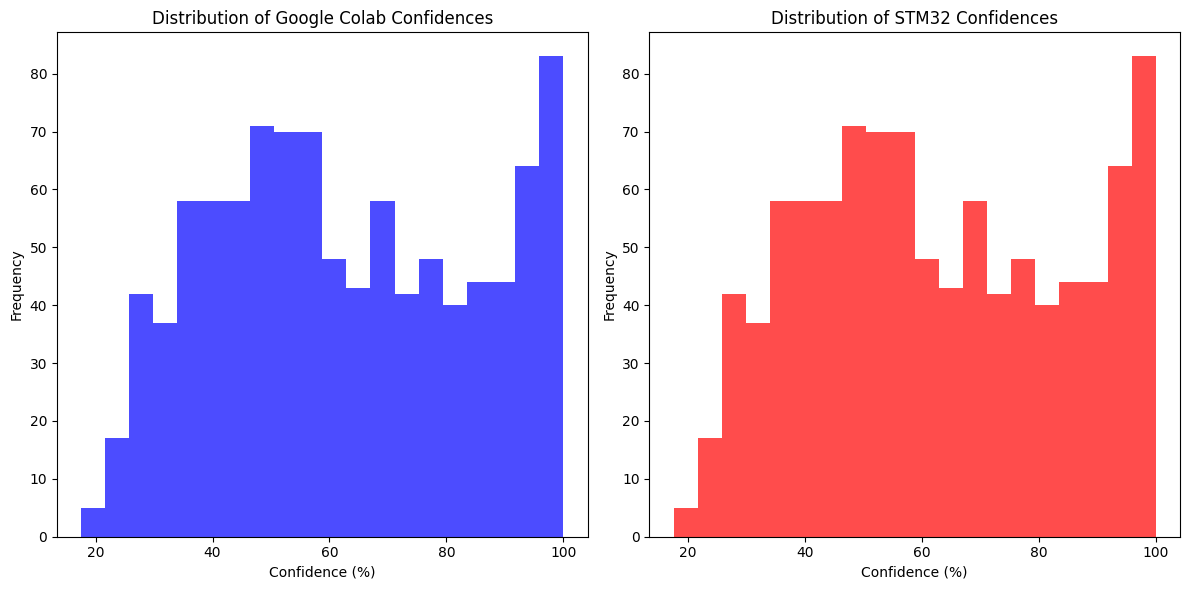

Results saved to comparison_results_hard_O2.txt

====== CONFIGURATION COMPARISON ======
Configuration | STM32 Accuracy | Accuracy Diff | Prediction Diffs | Avg Confidence Diff
-------------|----------------|---------------|------------------|-------------------
soft_O0       |          59.90% |          0.00% |                  0 |                0.00%
softfp_O0     |          59.90% |          0.00% |                  0 |                0.00%
hard_O0       |          59.90% |          0.00% |                  0 |                0.00%
hard_O1       |          59.90% |          0.00% |                  0 |                0.00%
hard_O2       |          59.90% |          0.00% |                  0 |                0.00%


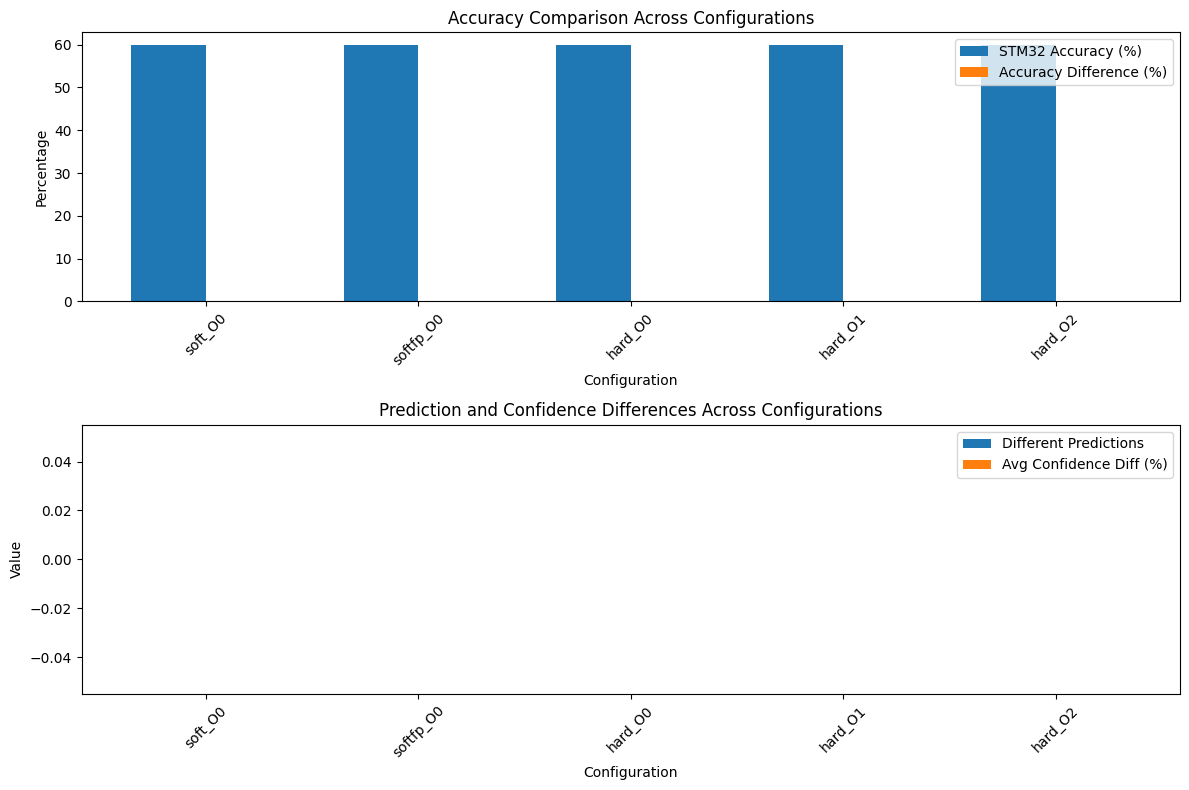


Run another analysis?
1. Yes
2. No
Enter choice (1-2): 1

Select FP ABI setting:
1. soft
2. softfp
3. hard
Enter choice (1-3): 3

Select compiler optimization:
1. O0
2. O1
3. O2
4. O3
5. Ofast
6. Og
7. Os
8. Oz
Enter choice (1-8): 4

Using FP ABI: hard, Optimization: O3

STM32 file options:
1. stm32_soft_O0_predictions (1).txt
2. stm32_softfp_O0_predictions.txt
3. stm32_hard_O0_predictions.txt
4. stm32_hard_O1_predictions.txt
5. stm32_hard_O2_predictions.txt
6. Upload a new STM32 file
Select file (1-6): 6
Upload a new STM32 predictions file:


Saving stm32_hard_O3_predictions.txt to stm32_hard_O3_predictions.txt
Added new file: stm32_hard_O3_predictions.txt

Analyzing performance for stm32_hard_O3_predictions.txt_hard_O3...

====== COMPARISON RESULTS ======
STM32 Configuration: FP ABI = hard, Optimization = O3
Google Colab Accuracy: 59.90%
STM32 Accuracy: 59.90%
Accuracy Difference: 0.00%
Number of different predictions: 0 out of 1000
Number of cases where one model is correct and the other is wrong: 0
Average confidence difference: 0.00%
Standard deviation of confidence differences: 0.00%
Median confidence difference: 0.00%
25th percentile of confidence differences: 0.00%
75th percentile of confidence differences: 0.00%
Maximum confidence difference: 0.00% (Image #0)

====== RGB DIFFERENCE RESULTS ======
Average R difference: 0.00
Average G difference: 0.00
Average B difference: 0.00
Average RGB difference: 0.00

====== DETAILED COMPARISON (First 10 Images) ======
Image # | True Label | Colab Prediction | Colab Confidence |

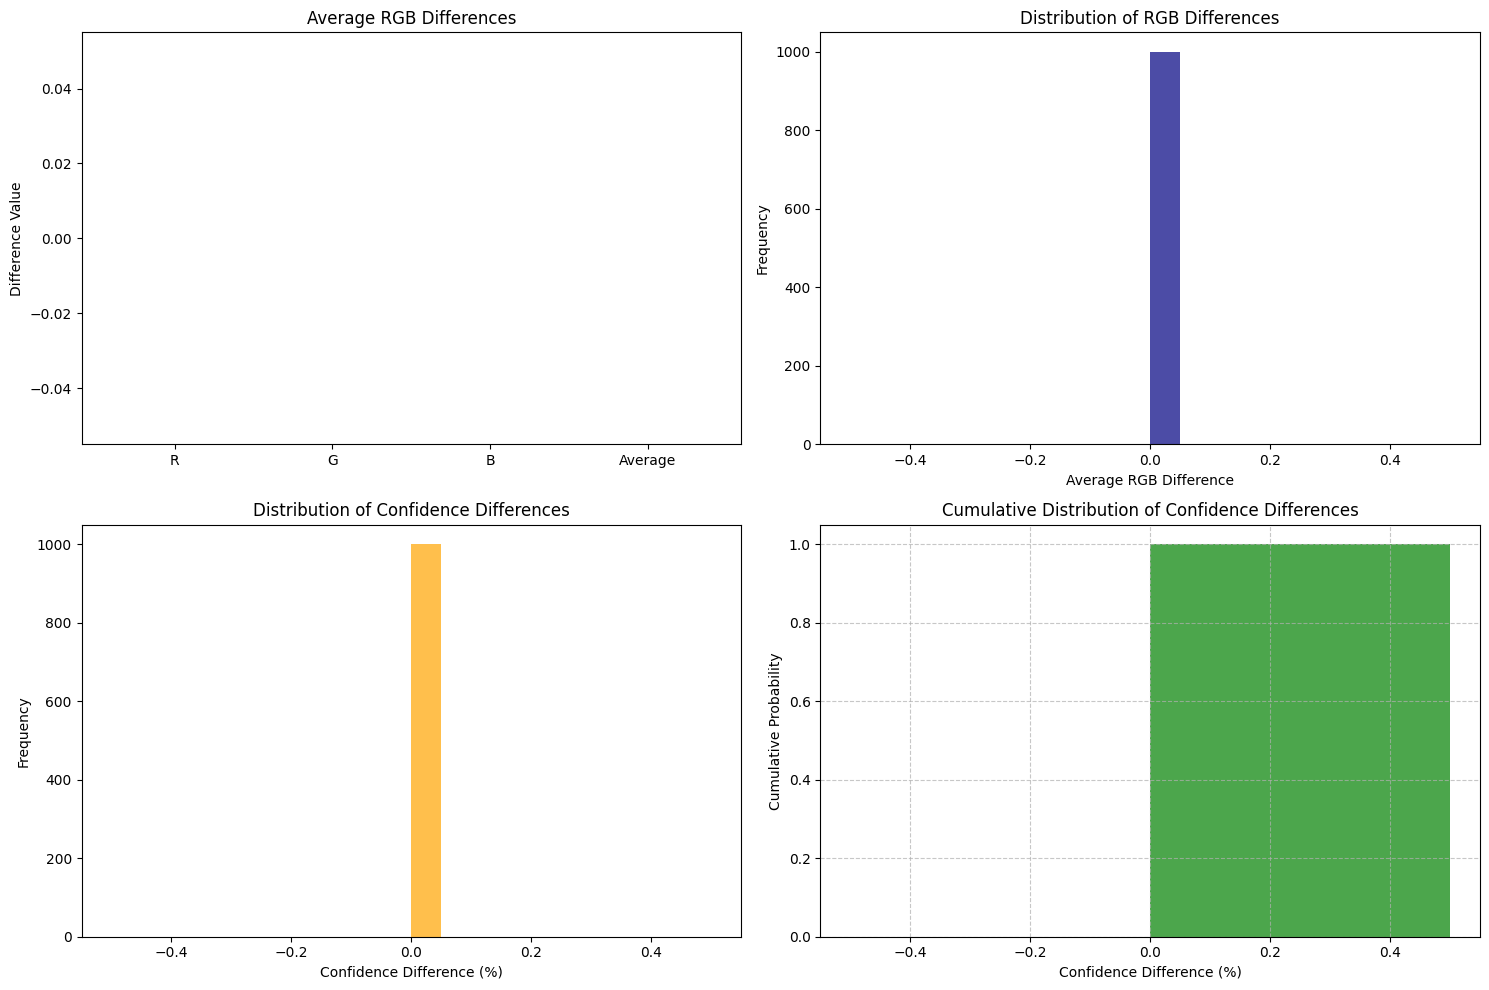

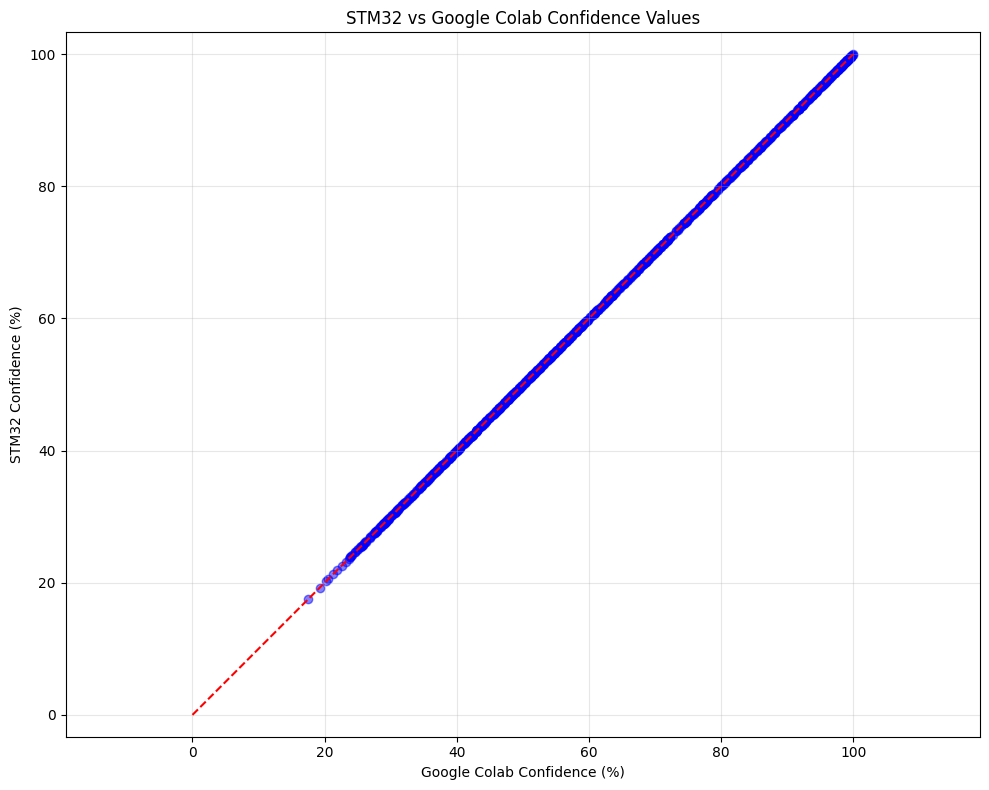

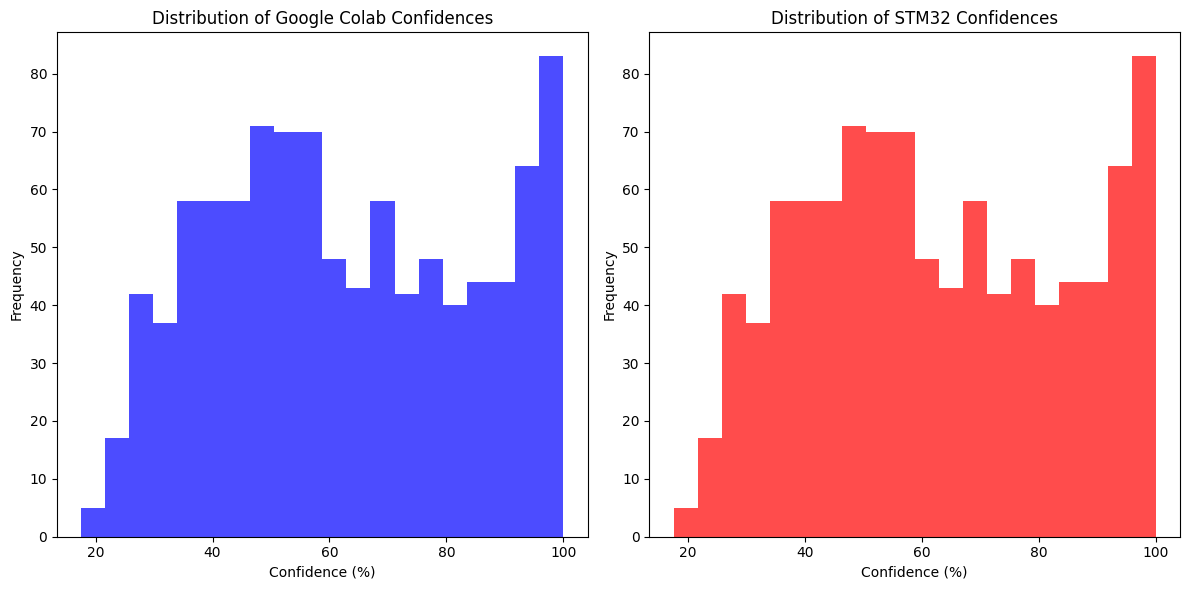

Results saved to comparison_results_hard_O3.txt

====== CONFIGURATION COMPARISON ======
Configuration | STM32 Accuracy | Accuracy Diff | Prediction Diffs | Avg Confidence Diff
-------------|----------------|---------------|------------------|-------------------
soft_O0       |          59.90% |          0.00% |                  0 |                0.00%
softfp_O0     |          59.90% |          0.00% |                  0 |                0.00%
hard_O0       |          59.90% |          0.00% |                  0 |                0.00%
hard_O1       |          59.90% |          0.00% |                  0 |                0.00%
hard_O2       |          59.90% |          0.00% |                  0 |                0.00%
hard_O3       |          59.90% |          0.00% |                  0 |                0.00%


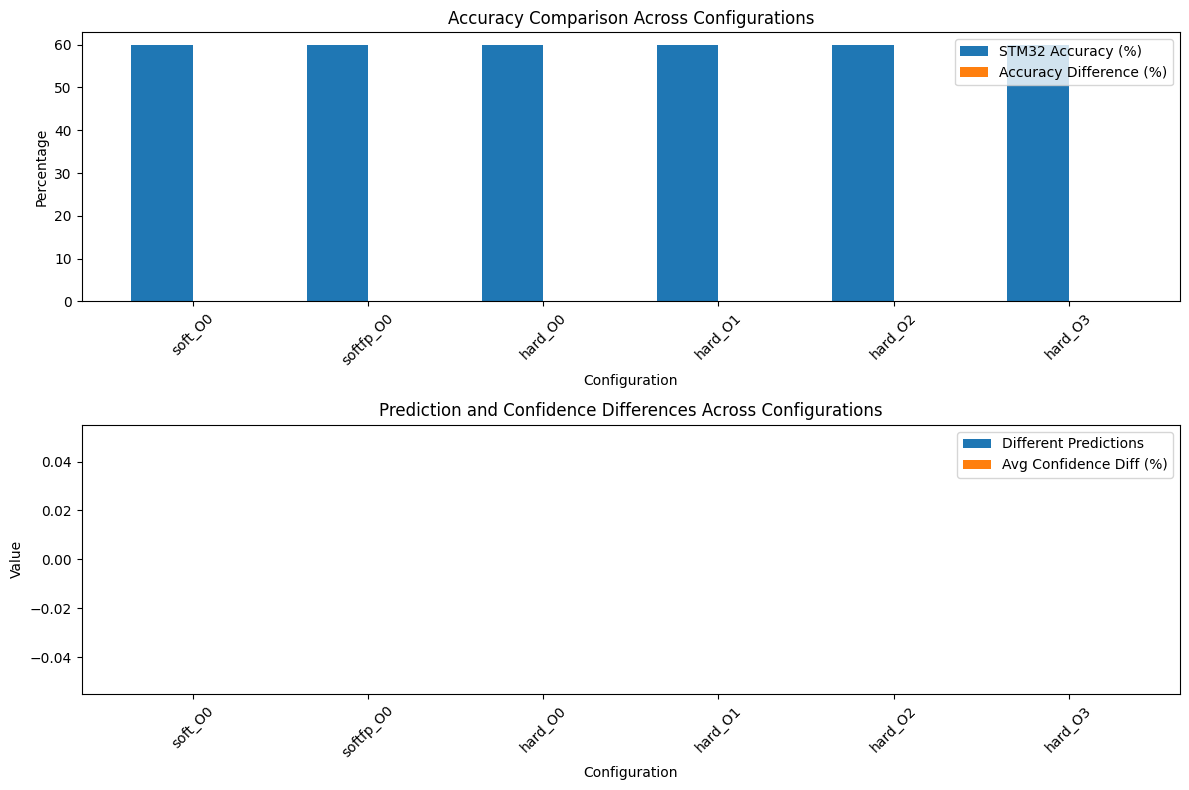


Run another analysis?
1. Yes
2. No
Enter choice (1-2): 1

Select FP ABI setting:
1. soft
2. softfp
3. hard
Enter choice (1-3): 3

Select compiler optimization:
1. O0
2. O1
3. O2
4. O3
5. Ofast
6. Og
7. Os
8. Oz
Enter choice (1-8): 5

Using FP ABI: hard, Optimization: Ofast

STM32 file options:
1. stm32_soft_O0_predictions (1).txt
2. stm32_softfp_O0_predictions.txt
3. stm32_hard_O0_predictions.txt
4. stm32_hard_O1_predictions.txt
5. stm32_hard_O2_predictions.txt
6. stm32_hard_O3_predictions.txt
7. Upload a new STM32 file
Select file (1-7): 7
Upload a new STM32 predictions file:


Saving stm32_hard_Ofast_predictions.txt to stm32_hard_Ofast_predictions.txt
Added new file: stm32_hard_Ofast_predictions.txt

Analyzing performance for stm32_hard_Ofast_predictions.txt_hard_Ofast...

====== COMPARISON RESULTS ======
STM32 Configuration: FP ABI = hard, Optimization = Ofast
Google Colab Accuracy: 59.90%
STM32 Accuracy: 59.90%
Accuracy Difference: 0.00%
Number of different predictions: 0 out of 1000
Number of cases where one model is correct and the other is wrong: 0
Average confidence difference: 0.00%
Standard deviation of confidence differences: 0.00%
Median confidence difference: 0.00%
25th percentile of confidence differences: 0.00%
75th percentile of confidence differences: 0.00%
Maximum confidence difference: 0.00% (Image #0)

====== RGB DIFFERENCE RESULTS ======
Average R difference: 0.00
Average G difference: 0.00
Average B difference: 0.00
Average RGB difference: 0.00

====== DETAILED COMPARISON (First 10 Images) ======
Image # | True Label | Colab Prediction | 

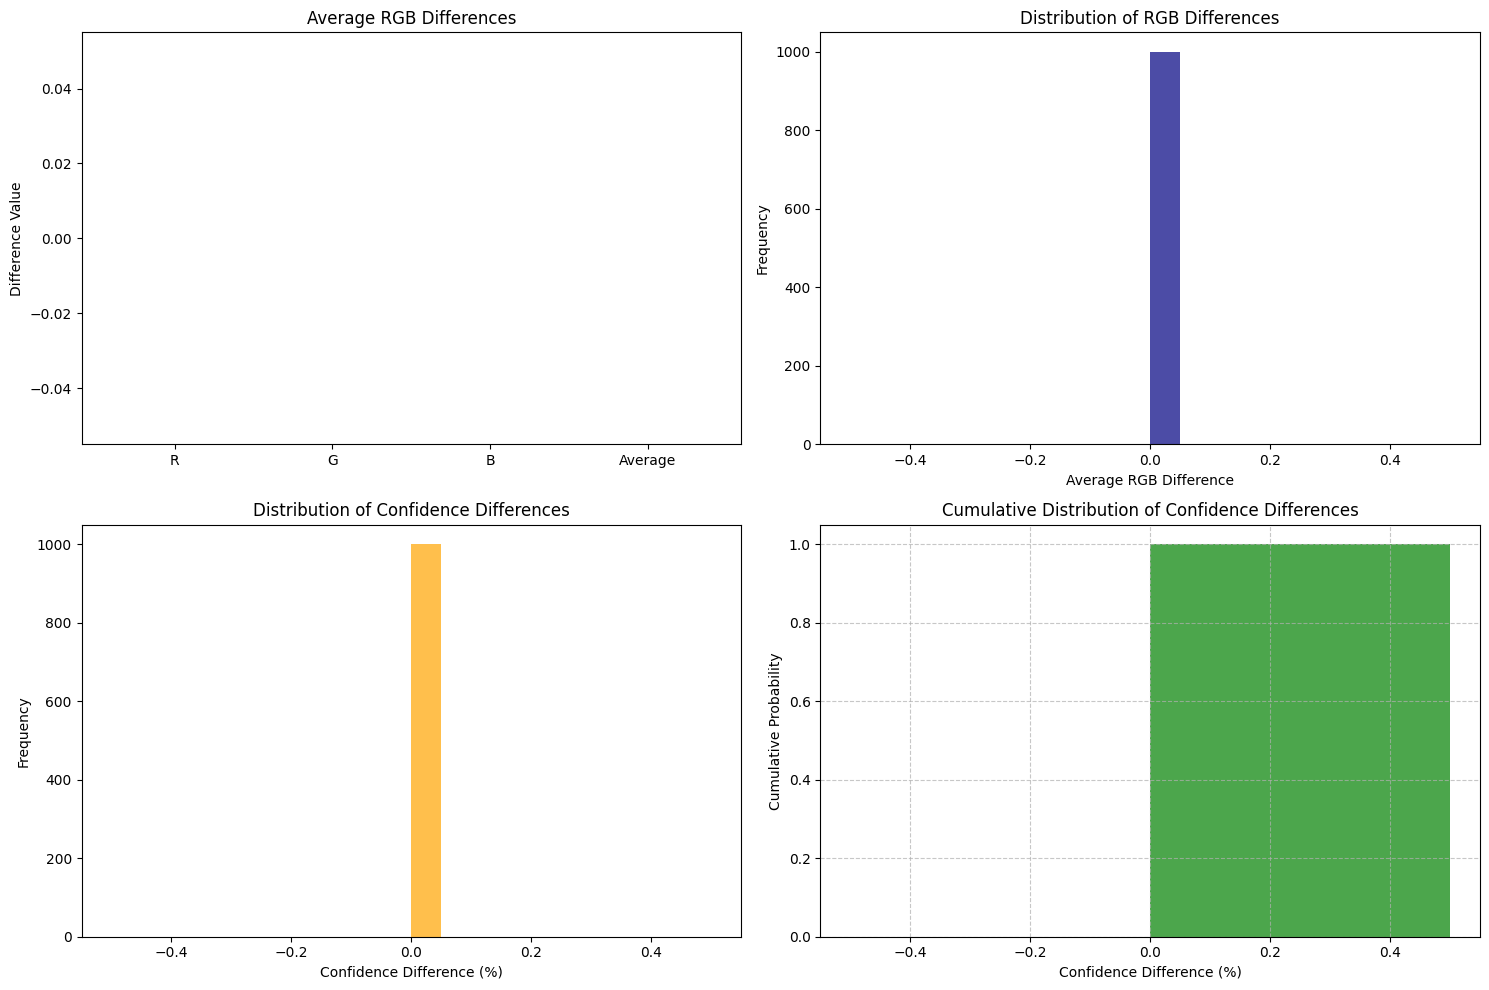

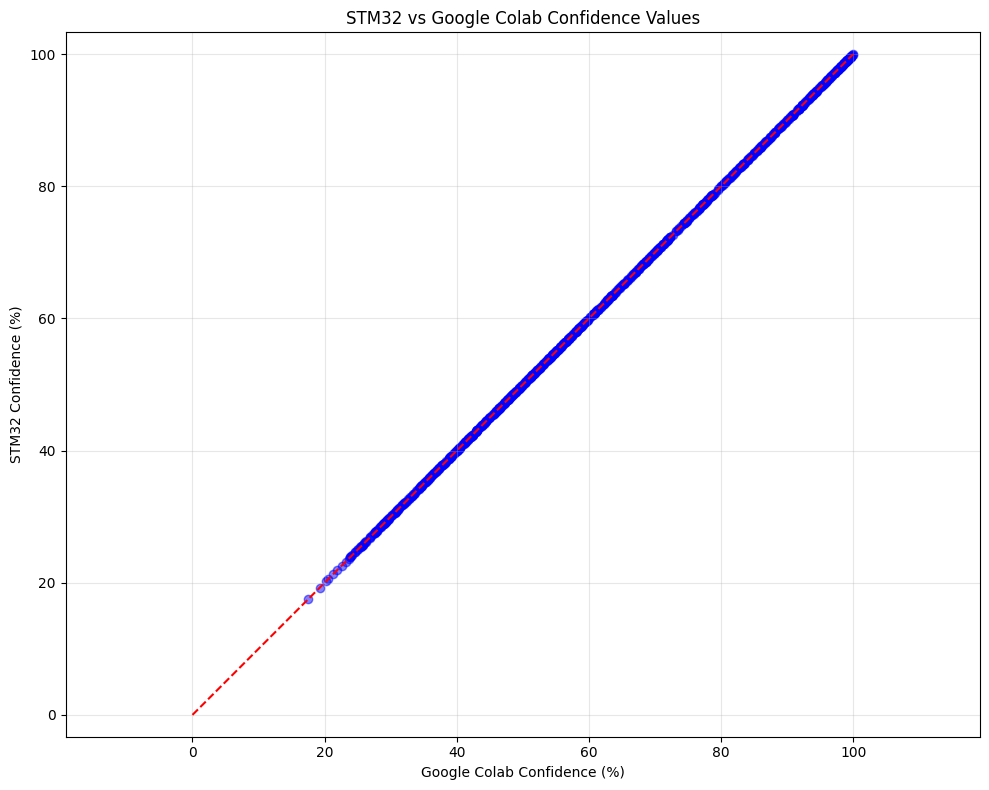

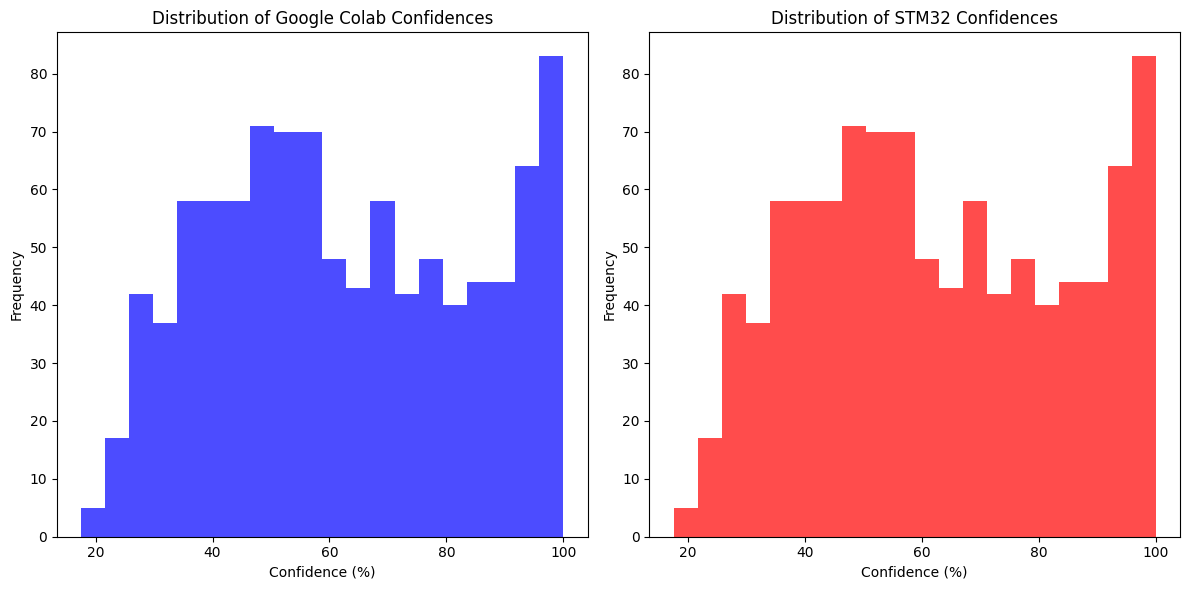

Results saved to comparison_results_hard_Ofast.txt

====== CONFIGURATION COMPARISON ======
Configuration | STM32 Accuracy | Accuracy Diff | Prediction Diffs | Avg Confidence Diff
-------------|----------------|---------------|------------------|-------------------
soft_O0       |          59.90% |          0.00% |                  0 |                0.00%
softfp_O0     |          59.90% |          0.00% |                  0 |                0.00%
hard_O0       |          59.90% |          0.00% |                  0 |                0.00%
hard_O1       |          59.90% |          0.00% |                  0 |                0.00%
hard_O2       |          59.90% |          0.00% |                  0 |                0.00%
hard_O3       |          59.90% |          0.00% |                  0 |                0.00%
hard_Ofast    |          59.90% |          0.00% |                  0 |                0.00%


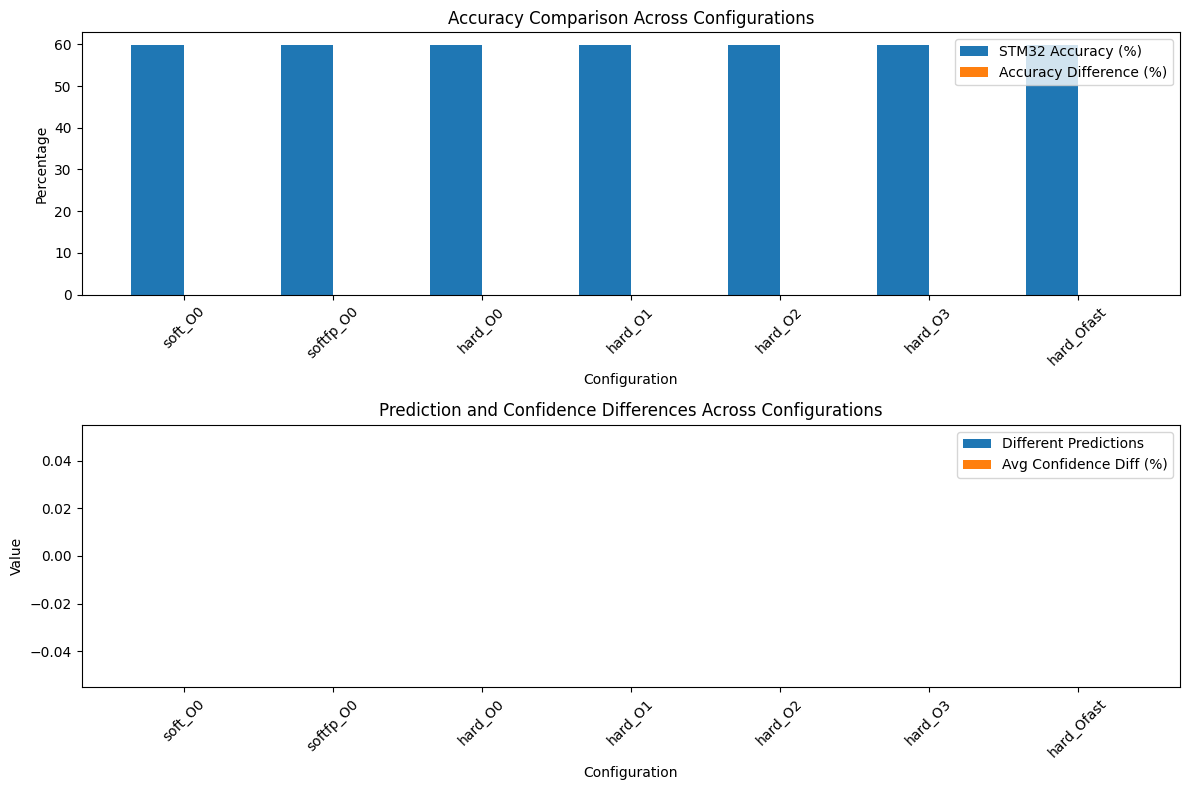


Run another analysis?
1. Yes
2. No
Enter choice (1-2): 1

Select FP ABI setting:
1. soft
2. softfp
3. hard
Enter choice (1-3): 3

Select compiler optimization:
1. O0
2. O1
3. O2
4. O3
5. Ofast
6. Og
7. Os
8. Oz
Enter choice (1-8): 6

Using FP ABI: hard, Optimization: Og

STM32 file options:
1. stm32_soft_O0_predictions (1).txt
2. stm32_softfp_O0_predictions.txt
3. stm32_hard_O0_predictions.txt
4. stm32_hard_O1_predictions.txt
5. stm32_hard_O2_predictions.txt
6. stm32_hard_O3_predictions.txt
7. stm32_hard_Ofast_predictions.txt
8. Upload a new STM32 file
Select file (1-8): 8
Upload a new STM32 predictions file:


Saving stm32_hard_Ofast_predictions.txt to stm32_hard_Ofast_predictions (1).txt
Added new file: stm32_hard_Ofast_predictions (1).txt

Analyzing performance for stm32_hard_Ofast_predictions (1).txt_hard_Og...

====== COMPARISON RESULTS ======
STM32 Configuration: FP ABI = hard, Optimization = Og
Google Colab Accuracy: 59.90%
STM32 Accuracy: 59.90%
Accuracy Difference: 0.00%
Number of different predictions: 0 out of 1000
Number of cases where one model is correct and the other is wrong: 0
Average confidence difference: 0.00%
Standard deviation of confidence differences: 0.00%
Median confidence difference: 0.00%
25th percentile of confidence differences: 0.00%
75th percentile of confidence differences: 0.00%
Maximum confidence difference: 0.00% (Image #0)

====== RGB DIFFERENCE RESULTS ======
Average R difference: 0.00
Average G difference: 0.00
Average B difference: 0.00
Average RGB difference: 0.00

====== DETAILED COMPARISON (First 10 Images) ======
Image # | True Label | Colab Predict

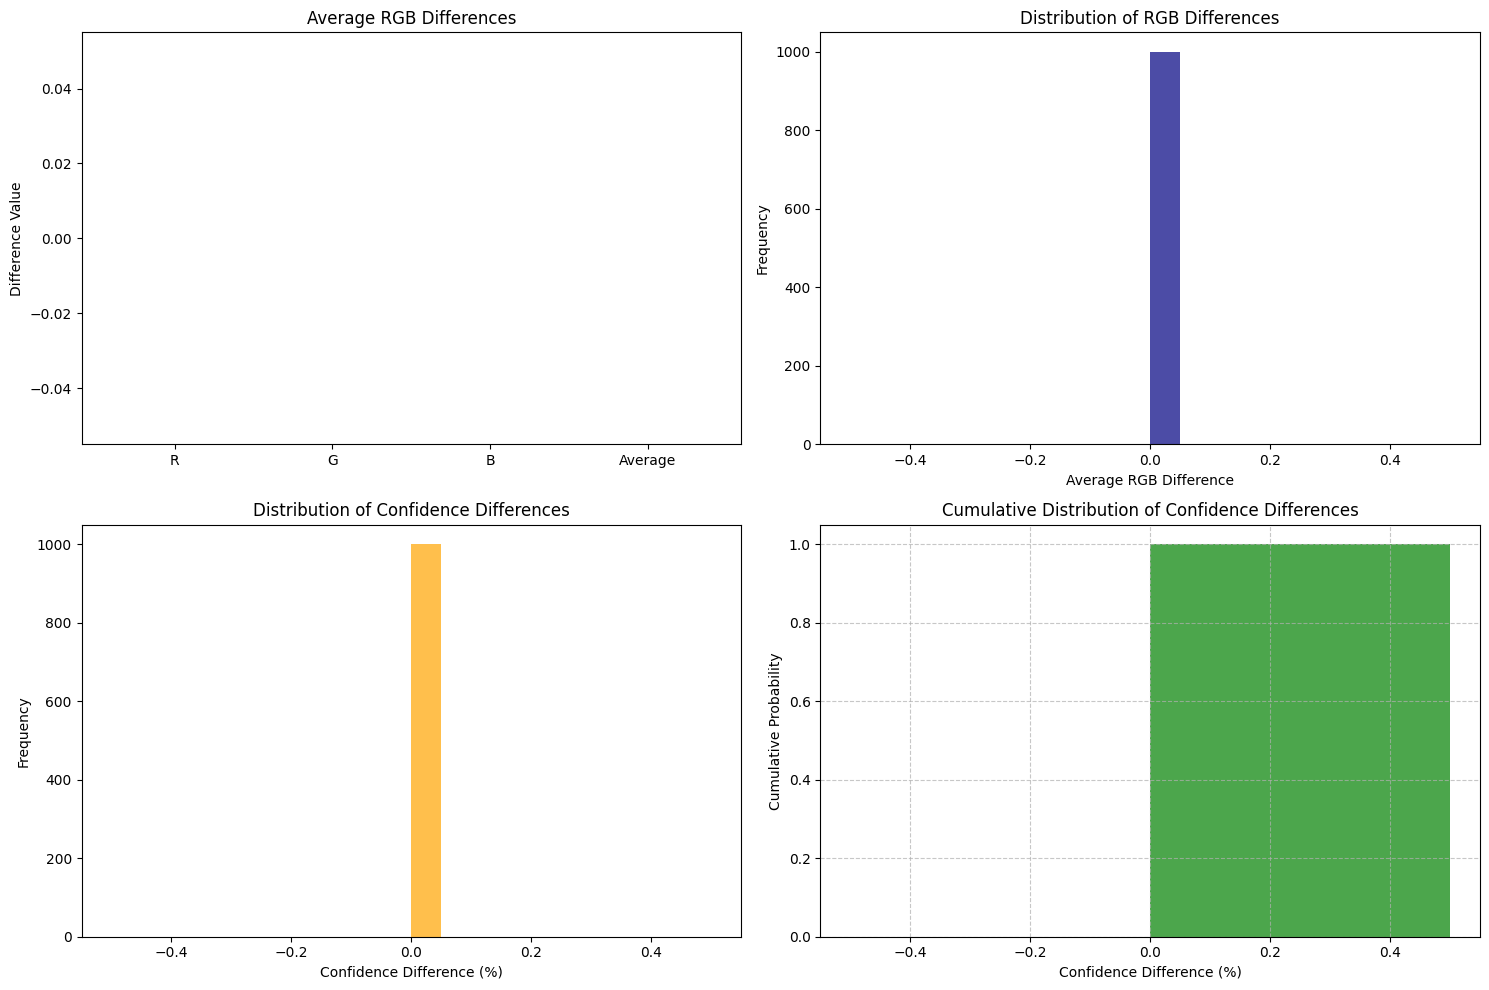

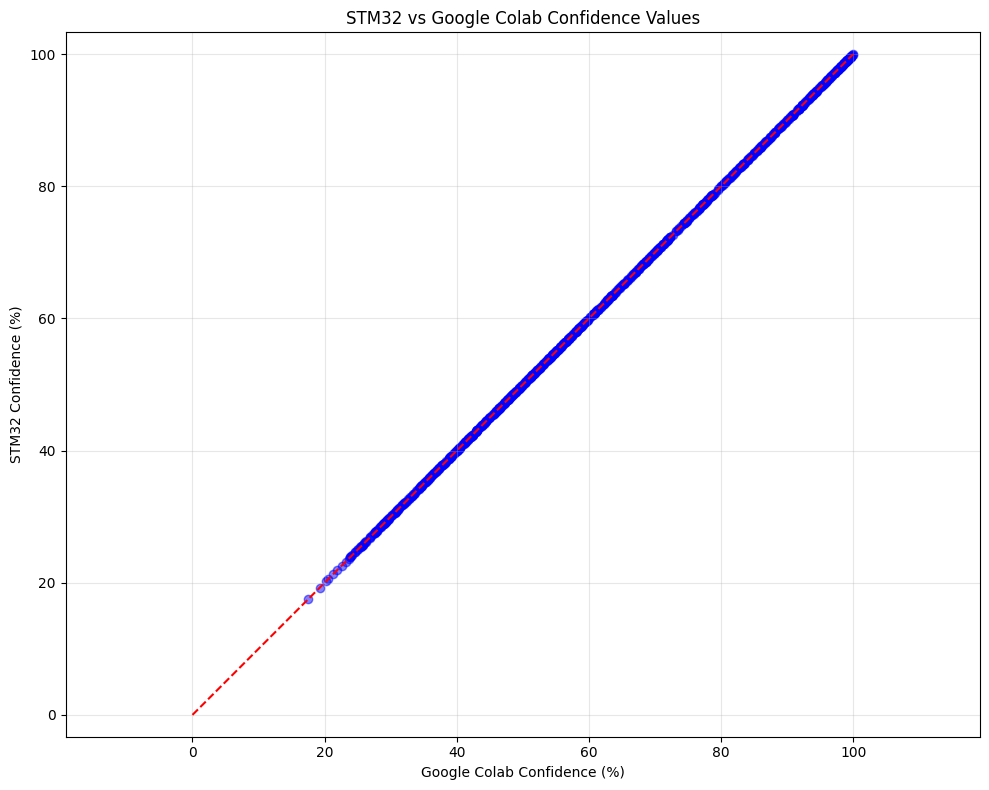

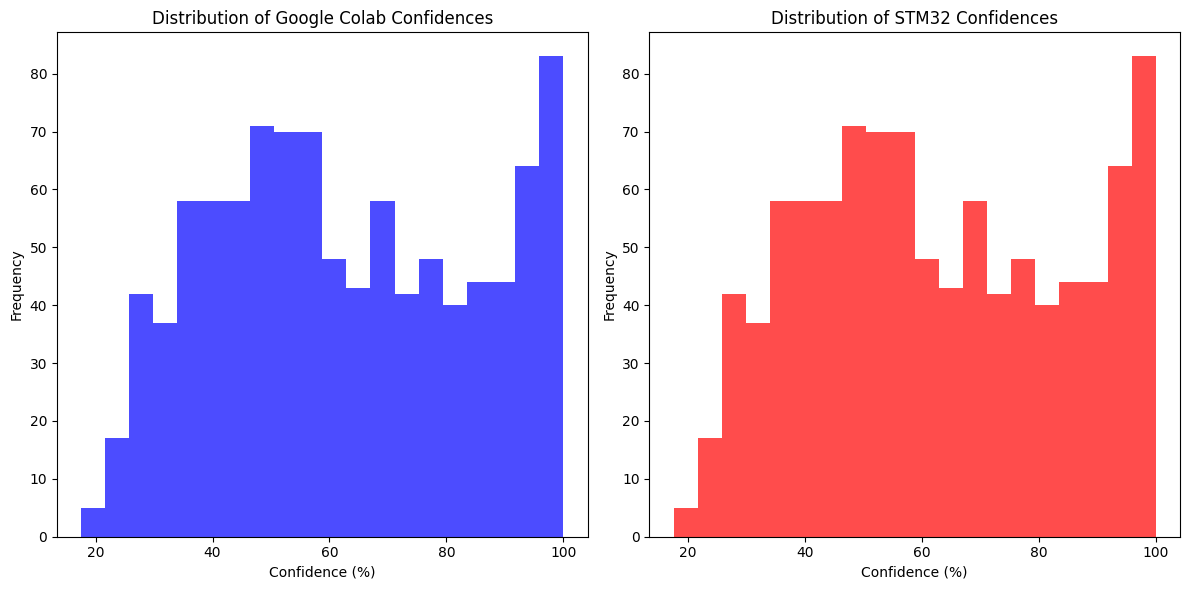

Results saved to comparison_results_hard_Og.txt

====== CONFIGURATION COMPARISON ======
Configuration | STM32 Accuracy | Accuracy Diff | Prediction Diffs | Avg Confidence Diff
-------------|----------------|---------------|------------------|-------------------
soft_O0       |          59.90% |          0.00% |                  0 |                0.00%
softfp_O0     |          59.90% |          0.00% |                  0 |                0.00%
hard_O0       |          59.90% |          0.00% |                  0 |                0.00%
hard_O1       |          59.90% |          0.00% |                  0 |                0.00%
hard_O2       |          59.90% |          0.00% |                  0 |                0.00%
hard_O3       |          59.90% |          0.00% |                  0 |                0.00%
hard_Ofast    |          59.90% |          0.00% |                  0 |                0.00%
hard_Og       |          59.90% |          0.00% |                  0 |                

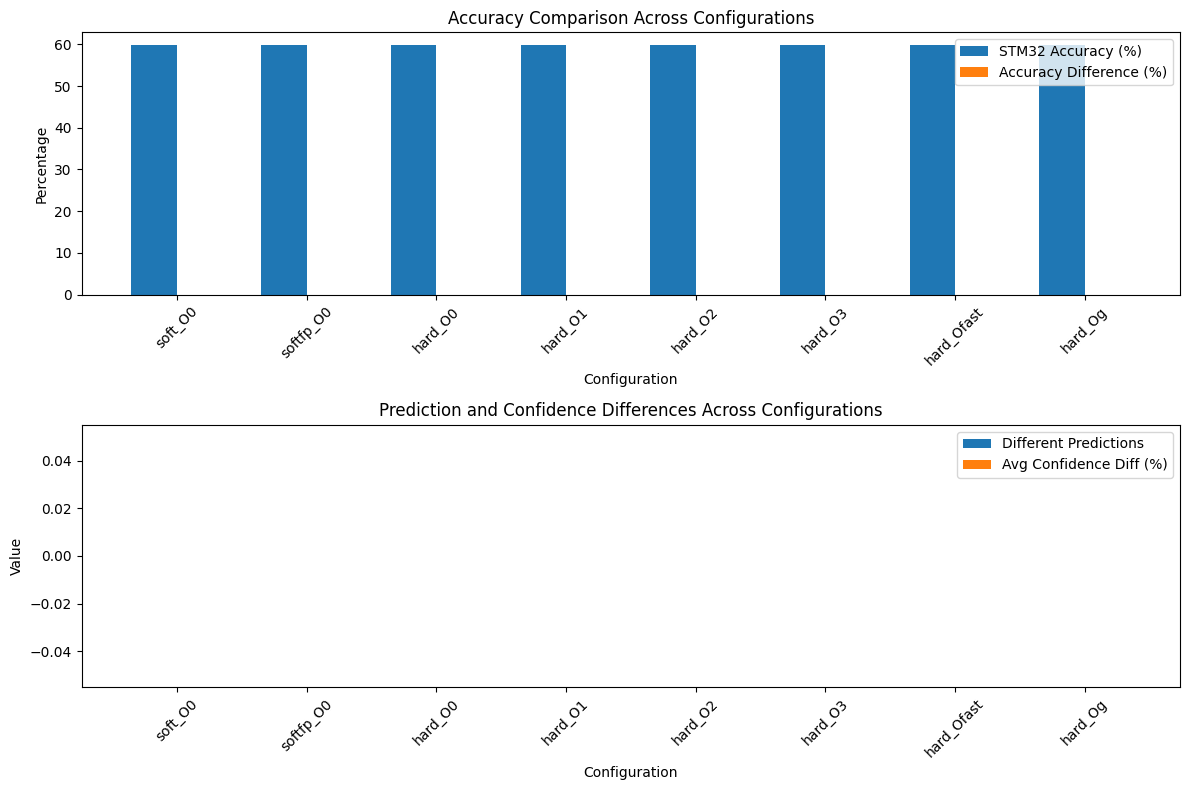


Run another analysis?
1. Yes
2. No
Enter choice (1-2): 1

Select FP ABI setting:
1. soft
2. softfp
3. hard
Enter choice (1-3): 3

Select compiler optimization:
1. O0
2. O1
3. O2
4. O3
5. Ofast
6. Og
7. Os
8. Oz
Enter choice (1-8): 6

Using FP ABI: hard, Optimization: Og

STM32 file options:
1. stm32_soft_O0_predictions (1).txt
2. stm32_softfp_O0_predictions.txt
3. stm32_hard_O0_predictions.txt
4. stm32_hard_O1_predictions.txt
5. stm32_hard_O2_predictions.txt
6. stm32_hard_O3_predictions.txt
7. stm32_hard_Ofast_predictions.txt
8. stm32_hard_Ofast_predictions (1).txt
9. Upload a new STM32 file
Select file (1-9): 9
Upload a new STM32 predictions file:


Saving stm32_hard_Og_predictions.txt to stm32_hard_Og_predictions.txt
Added new file: stm32_hard_Og_predictions.txt

Analyzing performance for stm32_hard_Og_predictions.txt_hard_Og...

====== COMPARISON RESULTS ======
STM32 Configuration: FP ABI = hard, Optimization = Og
Google Colab Accuracy: 59.90%
STM32 Accuracy: 59.90%
Accuracy Difference: 0.00%
Number of different predictions: 0 out of 1000
Number of cases where one model is correct and the other is wrong: 0
Average confidence difference: 0.00%
Standard deviation of confidence differences: 0.00%
Median confidence difference: 0.00%
25th percentile of confidence differences: 0.00%
75th percentile of confidence differences: 0.00%
Maximum confidence difference: 0.00% (Image #0)

====== RGB DIFFERENCE RESULTS ======
Average R difference: 0.00
Average G difference: 0.00
Average B difference: 0.00
Average RGB difference: 0.00

====== DETAILED COMPARISON (First 10 Images) ======
Image # | True Label | Colab Prediction | Colab Confidence |

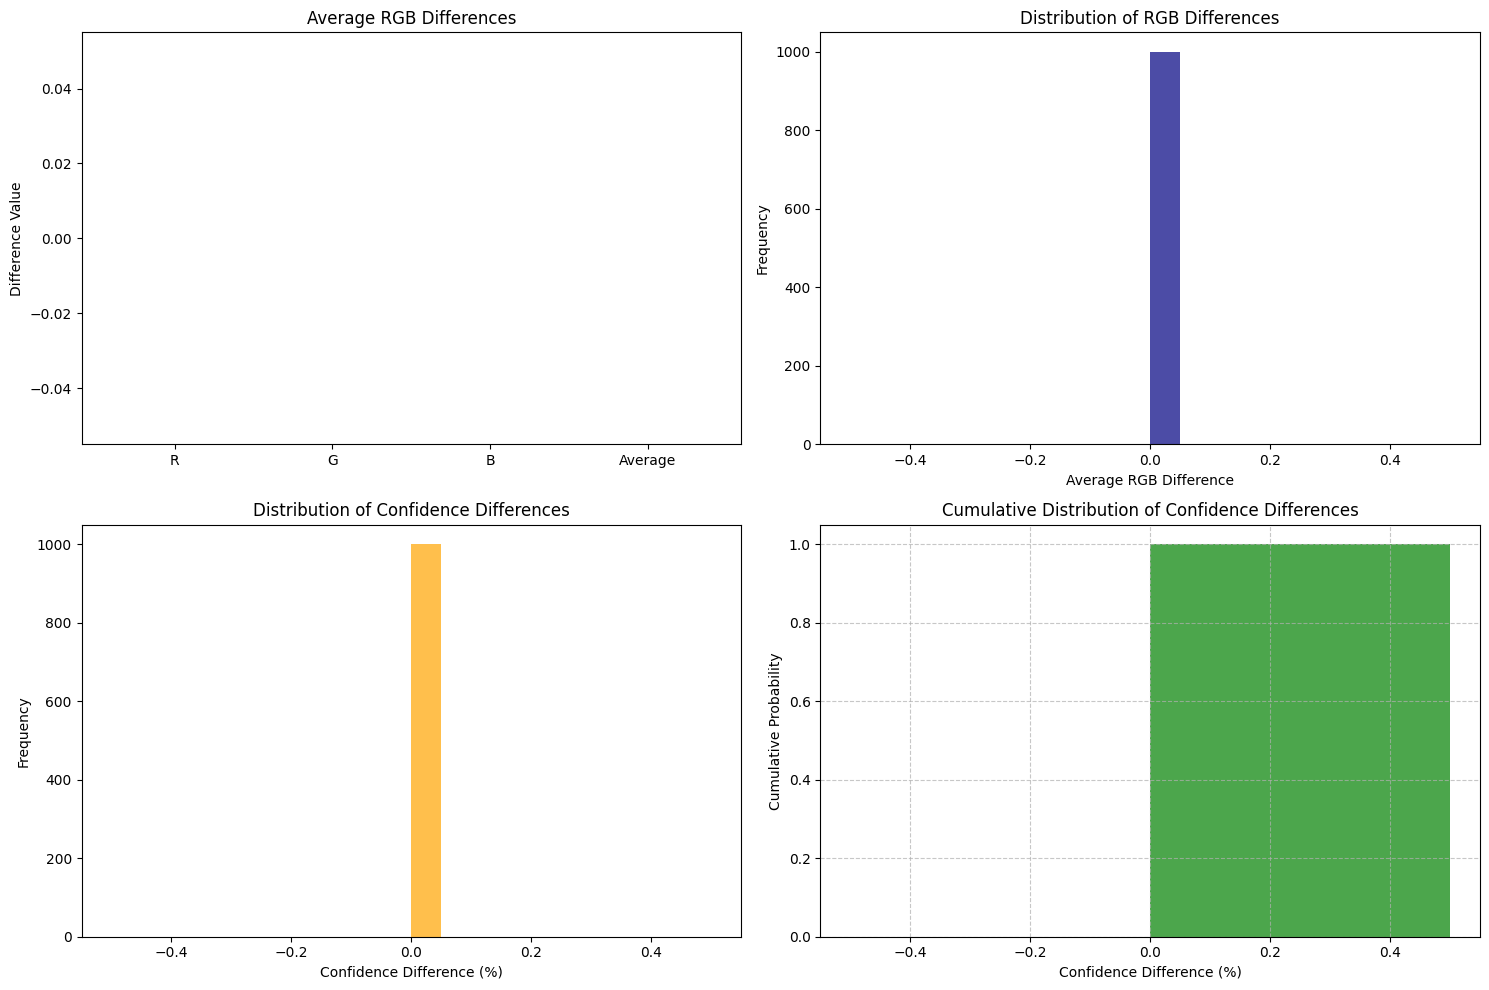

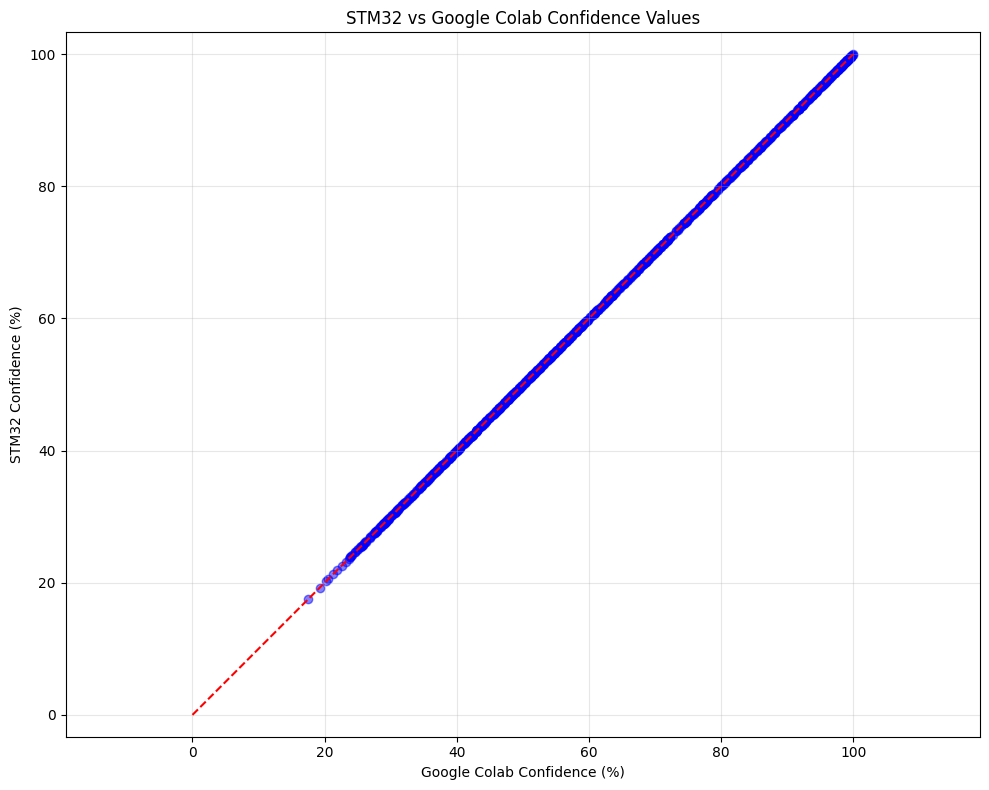

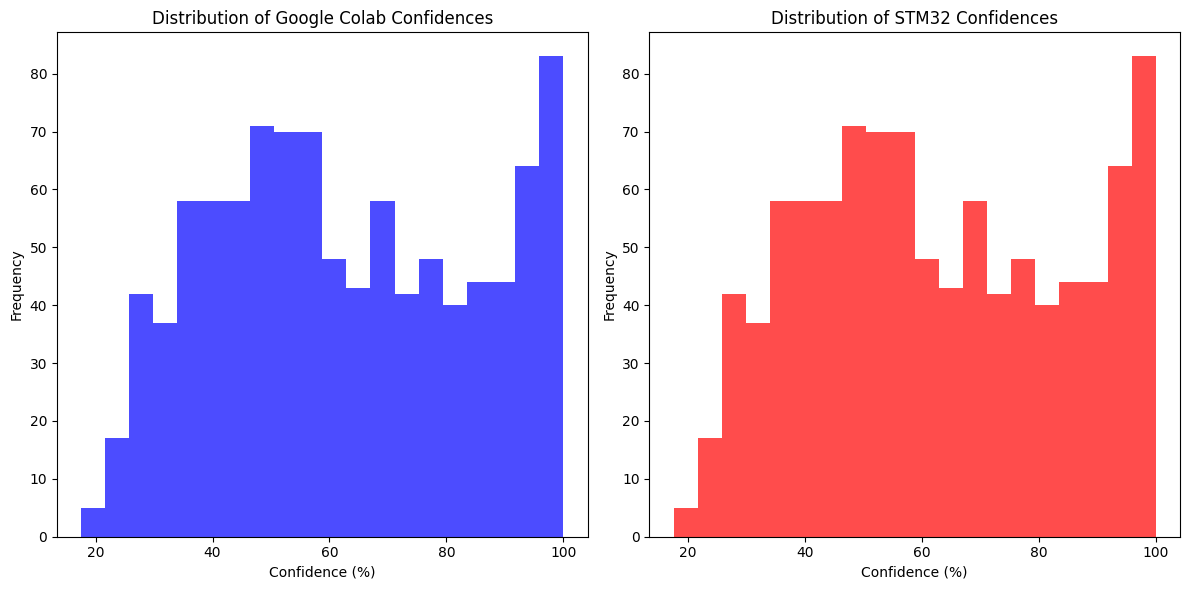

Results saved to comparison_results_hard_Og.txt

====== CONFIGURATION COMPARISON ======
Configuration | STM32 Accuracy | Accuracy Diff | Prediction Diffs | Avg Confidence Diff
-------------|----------------|---------------|------------------|-------------------
soft_O0       |          59.90% |          0.00% |                  0 |                0.00%
softfp_O0     |          59.90% |          0.00% |                  0 |                0.00%
hard_O0       |          59.90% |          0.00% |                  0 |                0.00%
hard_O1       |          59.90% |          0.00% |                  0 |                0.00%
hard_O2       |          59.90% |          0.00% |                  0 |                0.00%
hard_O3       |          59.90% |          0.00% |                  0 |                0.00%
hard_Ofast    |          59.90% |          0.00% |                  0 |                0.00%
hard_Og       |          59.90% |          0.00% |                  0 |                

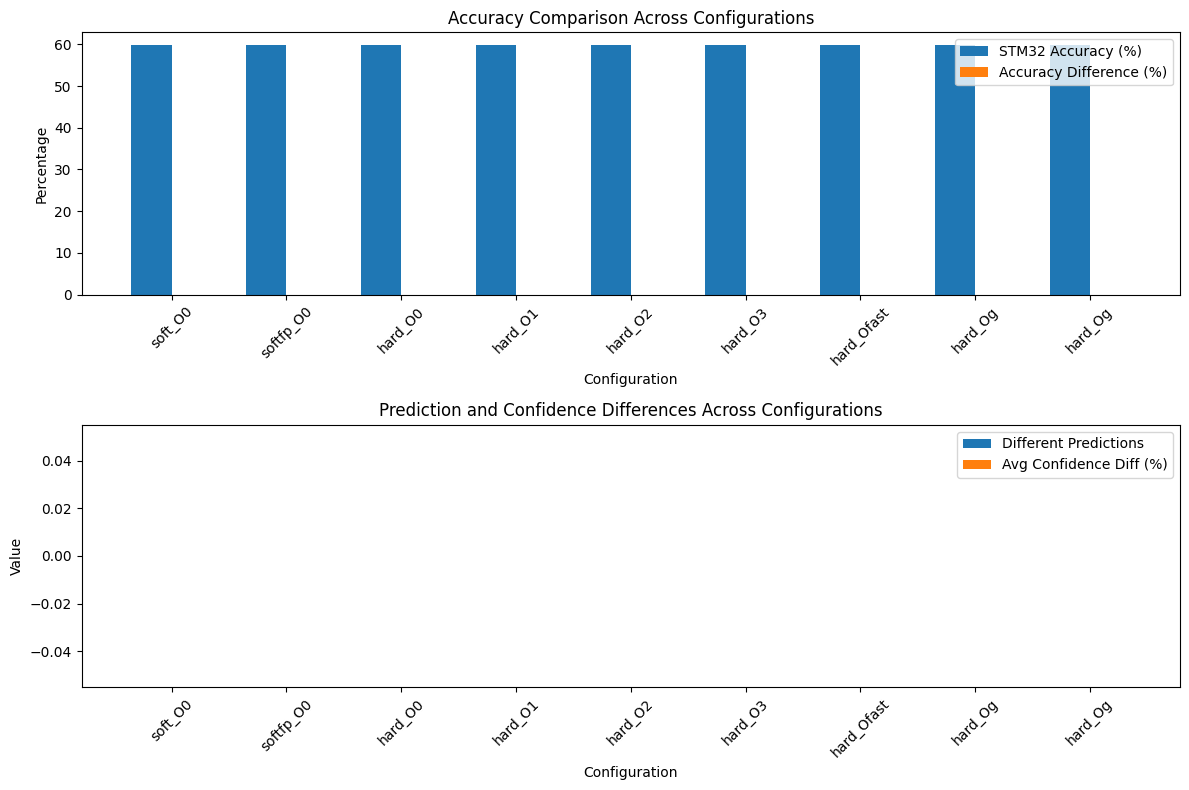


Run another analysis?
1. Yes
2. No
Enter choice (1-2): 1

Select FP ABI setting:
1. soft
2. softfp
3. hard
Enter choice (1-3): 3

Select compiler optimization:
1. O0
2. O1
3. O2
4. O3
5. Ofast
6. Og
7. Os
8. Oz
Enter choice (1-8): 7

Using FP ABI: hard, Optimization: Os

STM32 file options:
1. stm32_soft_O0_predictions (1).txt
2. stm32_softfp_O0_predictions.txt
3. stm32_hard_O0_predictions.txt
4. stm32_hard_O1_predictions.txt
5. stm32_hard_O2_predictions.txt
6. stm32_hard_O3_predictions.txt
7. stm32_hard_Ofast_predictions.txt
8. stm32_hard_Ofast_predictions (1).txt
9. stm32_hard_Og_predictions.txt
10. Upload a new STM32 file
Select file (1-10): 10
Upload a new STM32 predictions file:


Saving stm32_hard_Os_predictions.txt to stm32_hard_Os_predictions.txt
Added new file: stm32_hard_Os_predictions.txt

Analyzing performance for stm32_hard_Os_predictions.txt_hard_Os...

====== COMPARISON RESULTS ======
STM32 Configuration: FP ABI = hard, Optimization = Os
Google Colab Accuracy: 59.90%
STM32 Accuracy: 59.90%
Accuracy Difference: 0.00%
Number of different predictions: 0 out of 1000
Number of cases where one model is correct and the other is wrong: 0
Average confidence difference: 0.00%
Standard deviation of confidence differences: 0.00%
Median confidence difference: 0.00%
25th percentile of confidence differences: 0.00%
75th percentile of confidence differences: 0.00%
Maximum confidence difference: 0.00% (Image #0)

====== RGB DIFFERENCE RESULTS ======
Average R difference: 0.00
Average G difference: 0.00
Average B difference: 0.00
Average RGB difference: 0.00

====== DETAILED COMPARISON (First 10 Images) ======
Image # | True Label | Colab Prediction | Colab Confidence |

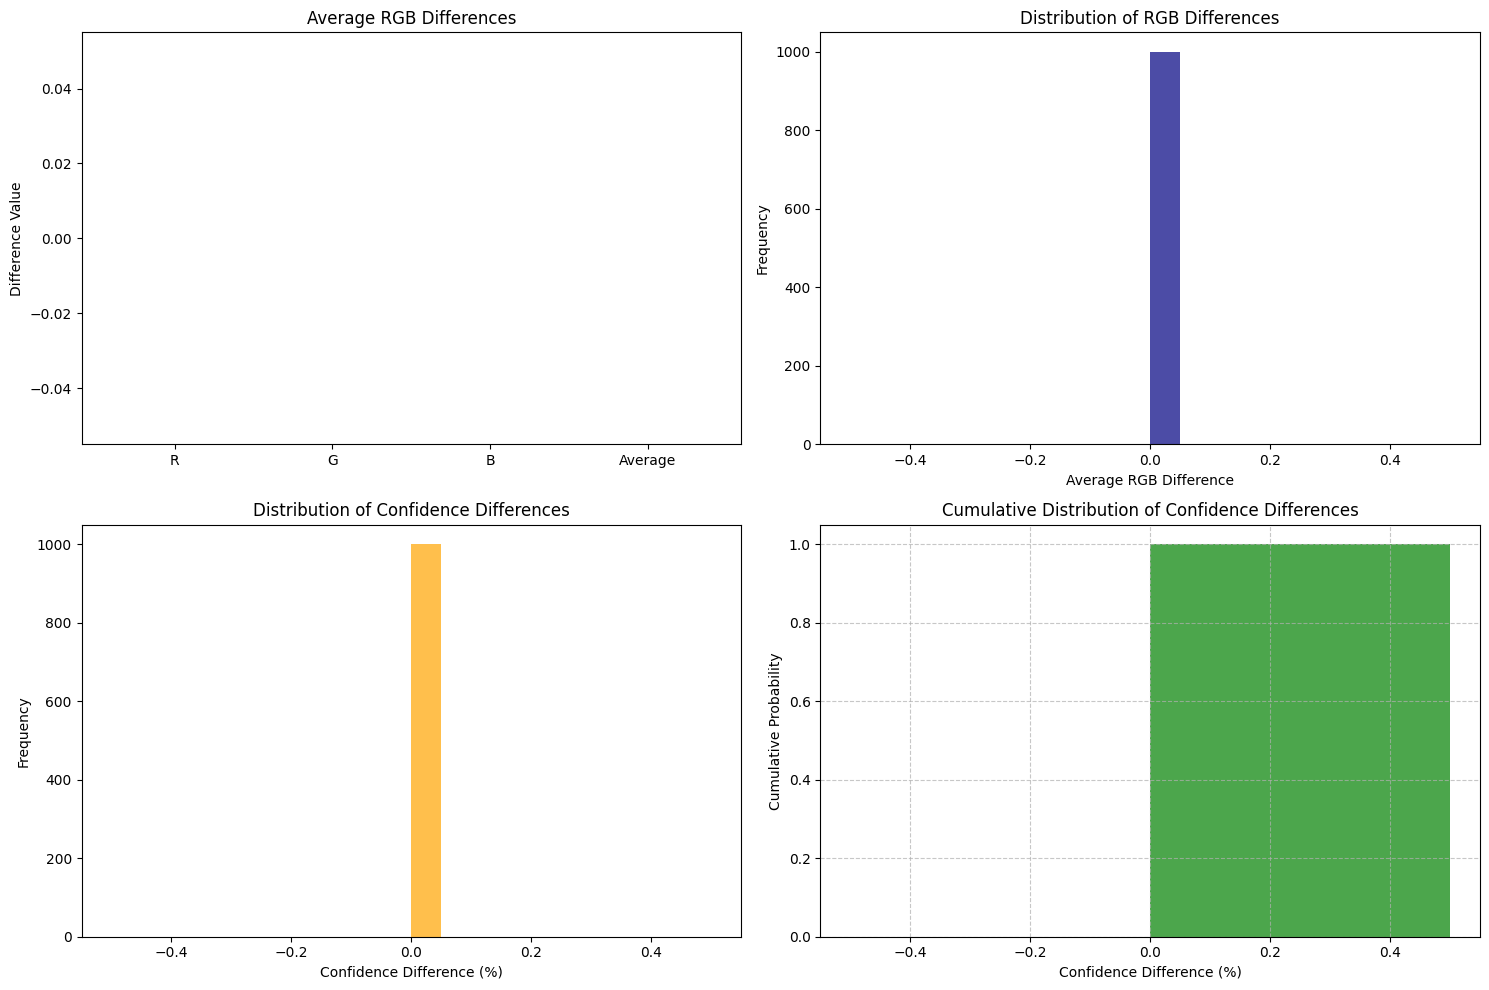

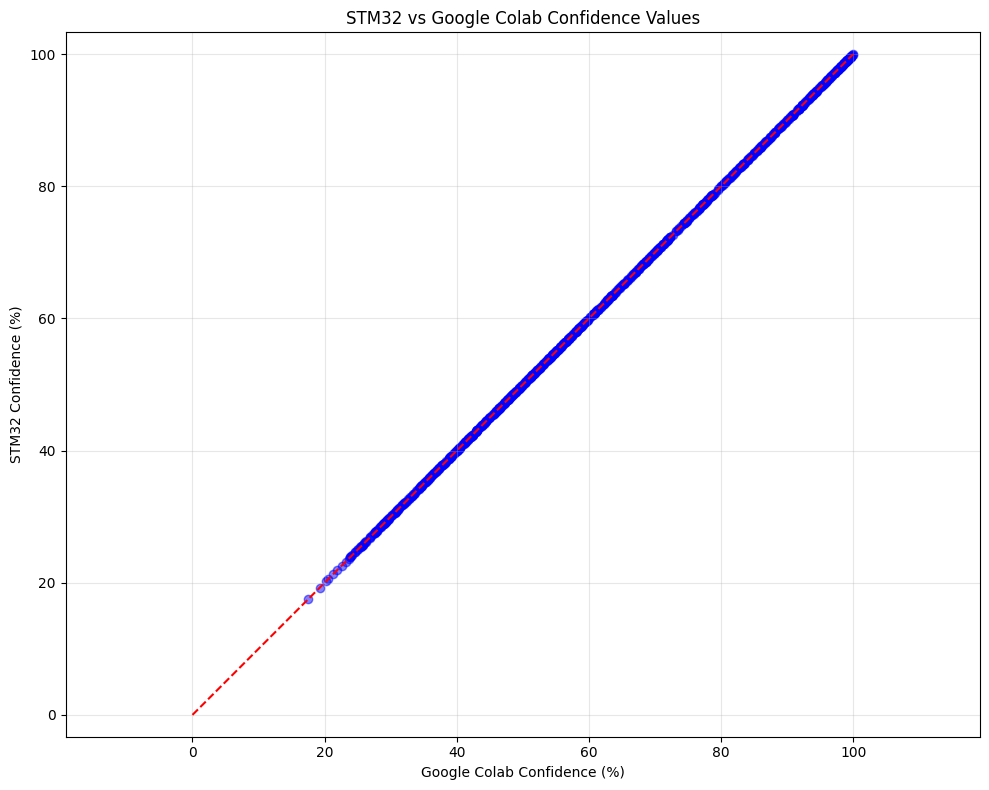

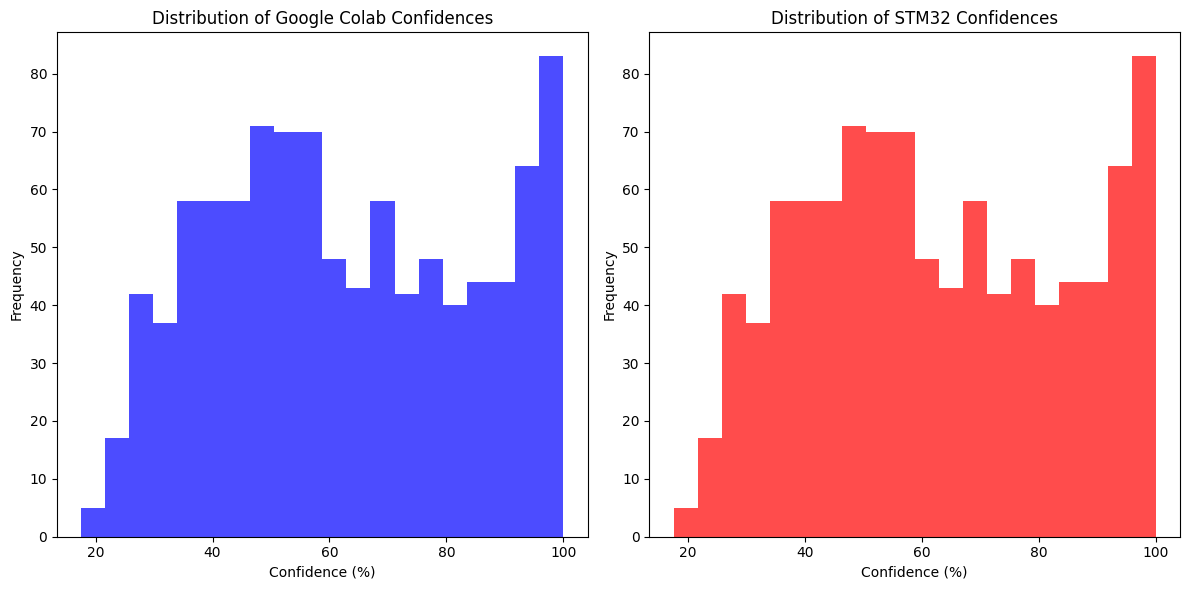

Results saved to comparison_results_hard_Os.txt

====== CONFIGURATION COMPARISON ======
Configuration | STM32 Accuracy | Accuracy Diff | Prediction Diffs | Avg Confidence Diff
-------------|----------------|---------------|------------------|-------------------
soft_O0       |          59.90% |          0.00% |                  0 |                0.00%
softfp_O0     |          59.90% |          0.00% |                  0 |                0.00%
hard_O0       |          59.90% |          0.00% |                  0 |                0.00%
hard_O1       |          59.90% |          0.00% |                  0 |                0.00%
hard_O2       |          59.90% |          0.00% |                  0 |                0.00%
hard_O3       |          59.90% |          0.00% |                  0 |                0.00%
hard_Ofast    |          59.90% |          0.00% |                  0 |                0.00%
hard_Og       |          59.90% |          0.00% |                  0 |                

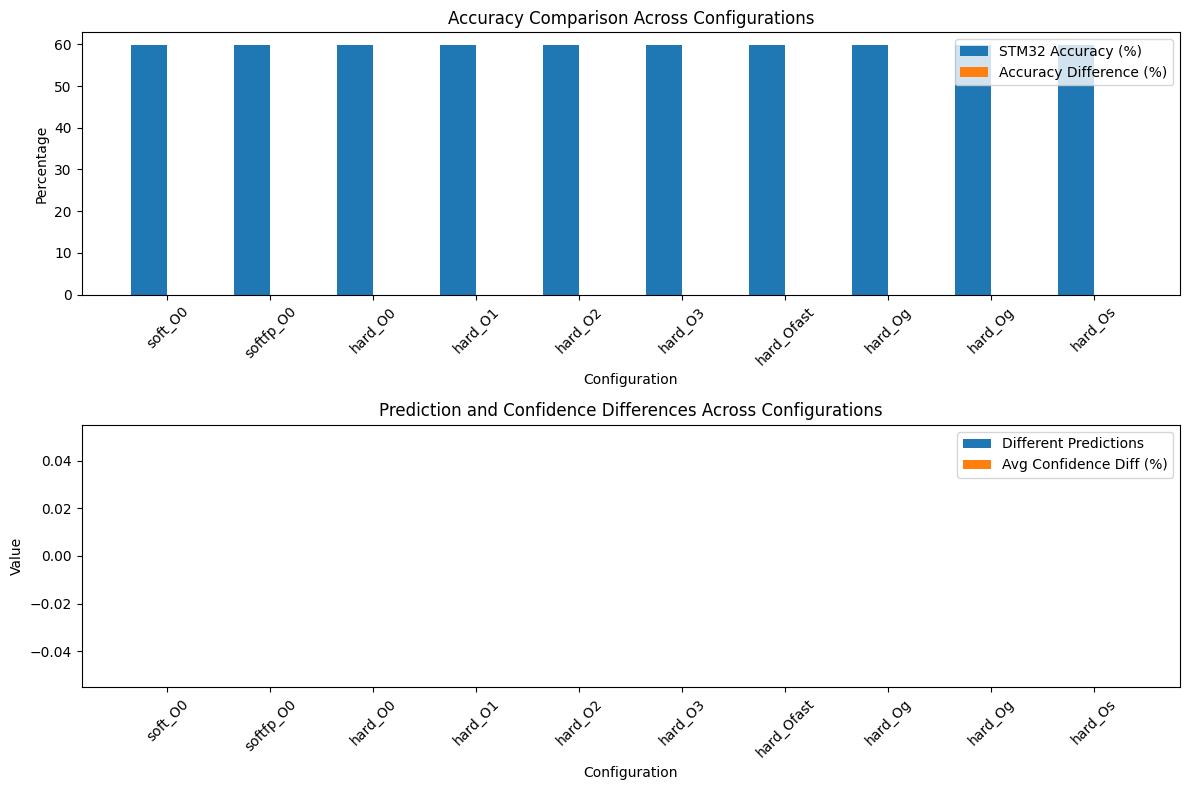


Run another analysis?
1. Yes
2. No
Enter choice (1-2): 1

Select FP ABI setting:
1. soft
2. softfp
3. hard
Enter choice (1-3): 3

Select compiler optimization:
1. O0
2. O1
3. O2
4. O3
5. Ofast
6. Og
7. Os
8. Oz
Enter choice (1-8): 8

Using FP ABI: hard, Optimization: Oz

STM32 file options:
1. stm32_soft_O0_predictions (1).txt
2. stm32_softfp_O0_predictions.txt
3. stm32_hard_O0_predictions.txt
4. stm32_hard_O1_predictions.txt
5. stm32_hard_O2_predictions.txt
6. stm32_hard_O3_predictions.txt
7. stm32_hard_Ofast_predictions.txt
8. stm32_hard_Ofast_predictions (1).txt
9. stm32_hard_Og_predictions.txt
10. stm32_hard_Os_predictions.txt
11. Upload a new STM32 file
Select file (1-11): 11
Upload a new STM32 predictions file:


Saving stm32_hard_Oz_predictions.txt to stm32_hard_Oz_predictions.txt
Added new file: stm32_hard_Oz_predictions.txt

Analyzing performance for stm32_hard_Oz_predictions.txt_hard_Oz...

====== COMPARISON RESULTS ======
STM32 Configuration: FP ABI = hard, Optimization = Oz
Google Colab Accuracy: 59.90%
STM32 Accuracy: 59.90%
Accuracy Difference: 0.00%
Number of different predictions: 0 out of 1000
Number of cases where one model is correct and the other is wrong: 0
Average confidence difference: 0.00%
Standard deviation of confidence differences: 0.00%
Median confidence difference: 0.00%
25th percentile of confidence differences: 0.00%
75th percentile of confidence differences: 0.00%
Maximum confidence difference: 0.00% (Image #0)

====== RGB DIFFERENCE RESULTS ======
Average R difference: 0.00
Average G difference: 0.00
Average B difference: 0.00
Average RGB difference: 0.00

====== DETAILED COMPARISON (First 10 Images) ======
Image # | True Label | Colab Prediction | Colab Confidence |

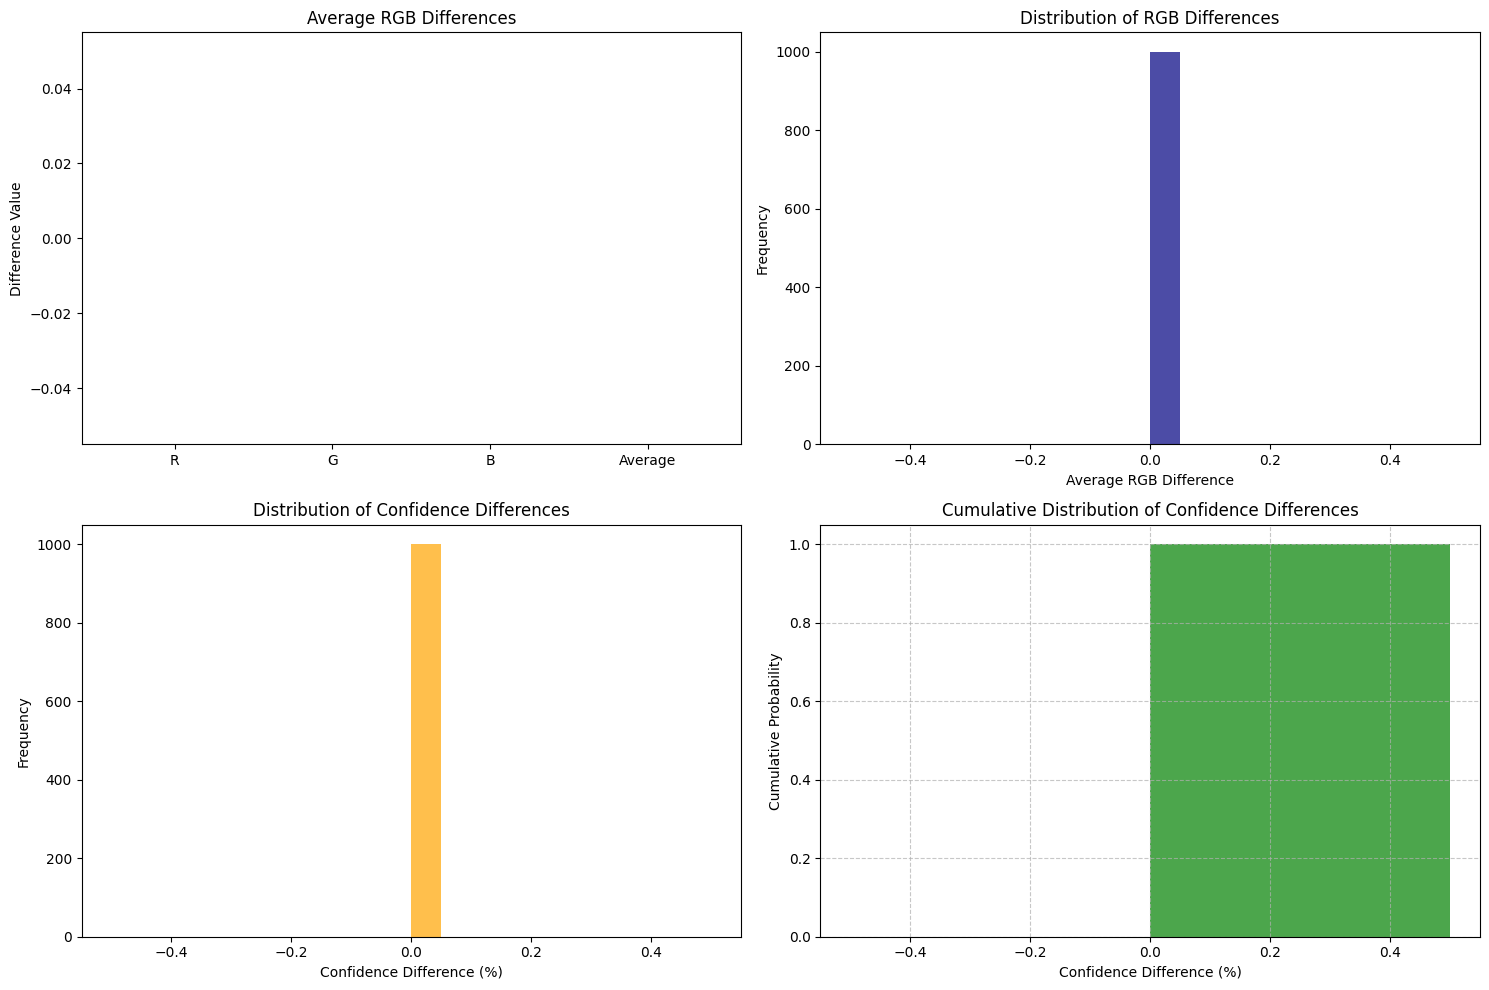

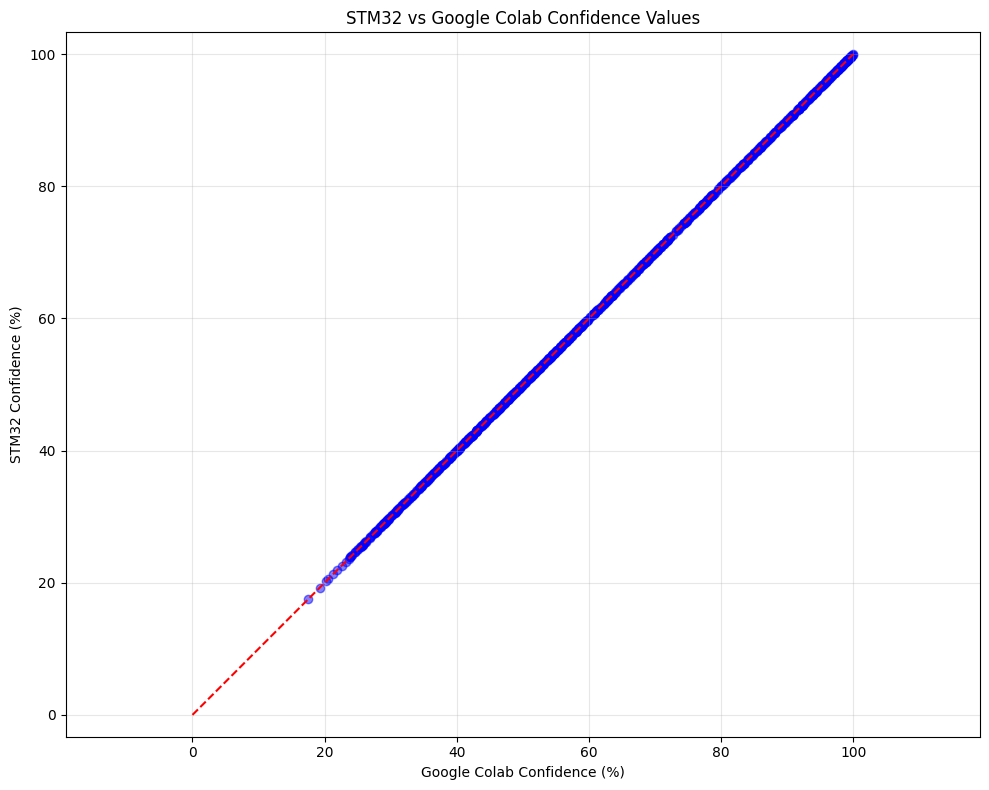

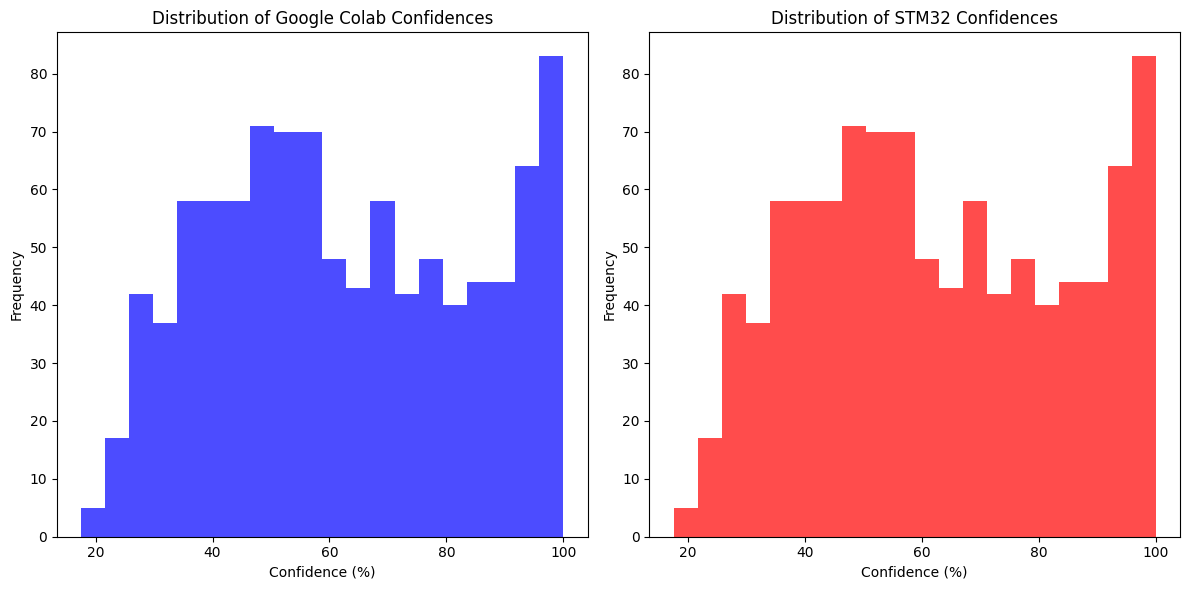

Results saved to comparison_results_hard_Oz.txt

====== CONFIGURATION COMPARISON ======
Configuration | STM32 Accuracy | Accuracy Diff | Prediction Diffs | Avg Confidence Diff
-------------|----------------|---------------|------------------|-------------------
soft_O0       |          59.90% |          0.00% |                  0 |                0.00%
softfp_O0     |          59.90% |          0.00% |                  0 |                0.00%
hard_O0       |          59.90% |          0.00% |                  0 |                0.00%
hard_O1       |          59.90% |          0.00% |                  0 |                0.00%
hard_O2       |          59.90% |          0.00% |                  0 |                0.00%
hard_O3       |          59.90% |          0.00% |                  0 |                0.00%
hard_Ofast    |          59.90% |          0.00% |                  0 |                0.00%
hard_Og       |          59.90% |          0.00% |                  0 |                

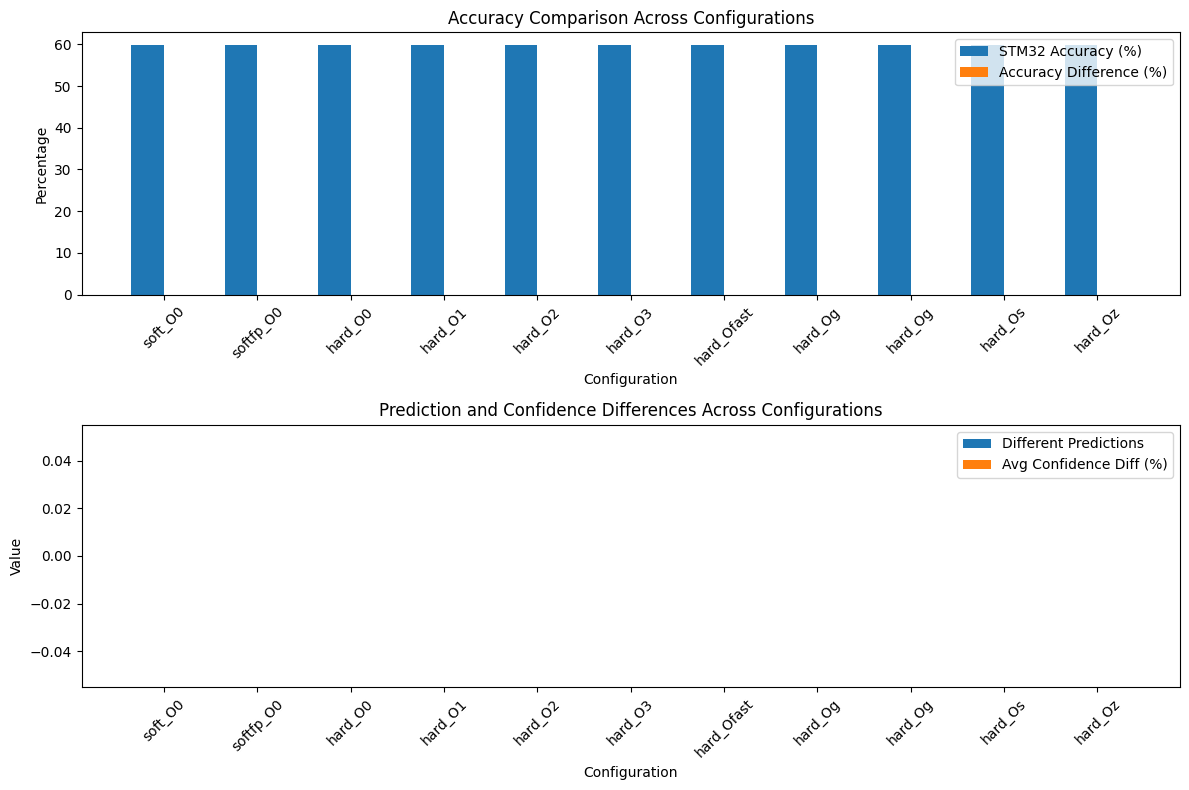


Run another analysis?
1. Yes
2. No
Enter choice (1-2): 2


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import re
import io
from google.colab import files
import argparse

def analyze_model_performance(stm32_content, colab_content, fp_abi=None, optimization=None):
    """
    Analyze and compare performance between STM32 and Google Colab model predictions

    Args:
        stm32_content: String content from STM32 predictions file
        colab_content: String content from Google Colab predictions file
        fp_abi: Floating point ABI setting (soft, softfp, hard)
        optimization: Compiler optimization level (O0, O1, O2, O3, Ofast, Og, Os, Oz)
    """
    # Extract STM32 predictions and confidences
    stm32_predictions = []
    stm32_confidences = []
    stm32_results = []
    stm32_true_labels = []

    pattern = r"Image #(\d+).*\nThe model predicts to be label (\d+) with confidence (\d+\.\d+)%.*\n(TRUE|FALSE)"
    matches = re.findall(pattern, stm32_content)

    for match in matches:
        image_idx = int(match[0])
        pred_label = int(match[1])
        confidence = float(match[2])
        is_correct = match[3] == "TRUE"

        # We'll infer the true label based on the correctness and prediction
        true_label = pred_label if is_correct else -1  # Placeholder

        stm32_predictions.append(pred_label)
        stm32_confidences.append(confidence)
        stm32_results.append(is_correct)
        stm32_true_labels.append(true_label)

    # Extract Google Colab predictions and confidences
    colab_predictions = []
    colab_confidences = []
    colab_results = []
    colab_true_labels = []

    # Try different patterns for Google Colab results
    colab_pattern = r"Image #(\d+).*\nThe model predicts to be label (\d+) with confidence (\d+\.\d+)%.*\n(TRUE|FALSE)"
    colab_matches = re.findall(colab_pattern, colab_content)

    if not colab_matches:  # Try alternative pattern if first one fails
        colab_pattern = r"Image (\d+).*\nPredicted: (\d+), Confidence: (\d+\.\d+)%, Actual: (\d+), (Correct|Incorrect)"
        colab_matches = re.findall(colab_pattern, colab_content)

        for match in colab_matches:
            image_idx = int(match[0])
            pred_label = int(match[1])
            confidence = float(match[2])
            true_label = int(match[3])
            is_correct = match[4] == "Correct"

            colab_predictions.append(pred_label)
            colab_confidences.append(confidence)
            colab_results.append(is_correct)
            colab_true_labels.append(true_label)

            # Update the true label in STM32 results if we have the same image
            if image_idx < len(stm32_true_labels):
                stm32_true_labels[image_idx] = true_label
    else:
        # First pattern matched
        for match in colab_matches:
            image_idx = int(match[0])
            pred_label = int(match[1])
            confidence = float(match[2])
            is_correct = match[3] == "TRUE"

            colab_predictions.append(pred_label)
            colab_confidences.append(confidence)
            colab_results.append(is_correct)
            # We don't have true label info in this pattern

    # Make sure we have the same number of images
    num_images = min(len(stm32_predictions), len(colab_predictions))

    # Function to convert a label to an RGB value (for visualization)
    def label_to_rgb(label, num_classes=10):
        # This is a simple mapping - you can customize based on your classes
        r = (label * 25) % 256
        g = (label * 50) % 256
        b = (label * 100) % 256
        return (r, g, b)

    # Calculate RGB differences
    rgb_differences = []
    total_r_diff = 0
    total_g_diff = 0
    total_b_diff = 0

    for i in range(num_images):
        colab_rgb = label_to_rgb(colab_predictions[i])
        stm32_rgb = label_to_rgb(stm32_predictions[i])

        r_diff = abs(colab_rgb[0] - stm32_rgb[0])
        g_diff = abs(colab_rgb[1] - stm32_rgb[1])
        b_diff = abs(colab_rgb[2] - stm32_rgb[2])

        total_r_diff += r_diff
        total_g_diff += g_diff
        total_b_diff += b_diff

        rgb_differences.append((r_diff, g_diff, b_diff))

    # Calculate average RGB difference
    avg_r_diff = total_r_diff / num_images
    avg_g_diff = total_g_diff / num_images
    avg_b_diff = total_b_diff / num_images

    # Compare results
    prediction_differences = 0
    correct_prediction_differences = 0
    total_confidence_diff = 0
    max_confidence_diff = 0
    max_confidence_idx = 0

    # Store all confidence differences for distribution analysis
    confidence_differences = []

    for i in range(num_images):
        # Check if predictions differ
        if colab_predictions[i] != stm32_predictions[i]:
            prediction_differences += 1

        # Check if correctness differs
        if colab_results[i] != stm32_results[i]:
            correct_prediction_differences += 1

        # Calculate confidence difference
        conf_diff = abs(colab_confidences[i] - stm32_confidences[i])
        confidence_differences.append(conf_diff)
        total_confidence_diff += conf_diff

        if conf_diff > max_confidence_diff:
            max_confidence_diff = conf_diff
            max_confidence_idx = i

    # Calculate averages
    avg_confidence_diff = total_confidence_diff / num_images
    colab_accuracy = sum(colab_results) / num_images * 100
    stm32_accuracy = sum(stm32_results) / num_images * 100

    # Calculate statistics for confidence differences
    conf_diff_std = np.std(confidence_differences)
    conf_diff_median = np.median(confidence_differences)
    conf_diff_25th = np.percentile(confidence_differences, 25)
    conf_diff_75th = np.percentile(confidence_differences, 75)

    # Print comparison results
    print("\n====== COMPARISON RESULTS ======")
    if fp_abi and optimization:
        print(f"STM32 Configuration: FP ABI = {fp_abi}, Optimization = {optimization}")
    print(f"Google Colab Accuracy: {colab_accuracy:.2f}%")
    print(f"STM32 Accuracy: {stm32_accuracy:.2f}%")
    print(f"Accuracy Difference: {abs(colab_accuracy - stm32_accuracy):.2f}%")
    print(f"Number of different predictions: {prediction_differences} out of {num_images}")
    print(f"Number of cases where one model is correct and the other is wrong: {correct_prediction_differences}")
    print(f"Average confidence difference: {avg_confidence_diff:.2f}%")
    print(f"Standard deviation of confidence differences: {conf_diff_std:.2f}%")
    print(f"Median confidence difference: {conf_diff_median:.2f}%")
    print(f"25th percentile of confidence differences: {conf_diff_25th:.2f}%")
    print(f"75th percentile of confidence differences: {conf_diff_75th:.2f}%")
    print(f"Maximum confidence difference: {max_confidence_diff:.2f}% (Image #{max_confidence_idx})")

    # Print RGB difference results
    print("\n====== RGB DIFFERENCE RESULTS ======")
    print(f"Average R difference: {avg_r_diff:.2f}")
    print(f"Average G difference: {avg_g_diff:.2f}")
    print(f"Average B difference: {avg_b_diff:.2f}")
    print(f"Average RGB difference: {(avg_r_diff + avg_g_diff + avg_b_diff) / 3:.2f}")

    # Print detailed comparison for the first 10 images
    print("\n====== DETAILED COMPARISON (First 10 Images) ======")
    print("Image # | True Label | Colab Prediction | Colab Confidence | STM32 Prediction | STM32 Confidence | RGB Difference | Colab Correct | STM32 Correct | Same Prediction")
    print("--------|------------|------------------|------------------|------------------|------------------|---------------|---------------|---------------|-----------------")

    for i in range(min(10, num_images)):
        # Determine true label - prefer colab_true_labels if available, otherwise use stm32_true_labels
        true_label = colab_true_labels[i] if i < len(colab_true_labels) and colab_true_labels[i] != -1 else stm32_true_labels[i]
        same_pred = colab_predictions[i] == stm32_predictions[i]
        rgb_diff = rgb_differences[i]
        avg_rgb_diff = sum(rgb_diff) / 3

        print(f"{i:8d} | {true_label:10d} | {colab_predictions[i]:16d} | {colab_confidences[i]:16.2f}% | {stm32_predictions[i]:16d} | {stm32_confidences[i]:16.2f}% | R:{rgb_diff[0]} G:{rgb_diff[1]} B:{rgb_diff[2]} | {colab_results[i]:13} | {stm32_results[i]:13} | {same_pred:17}")

    # Create visualizations
    plt.figure(figsize=(15, 10))

    # RGB difference visualizations
    plt.subplot(2, 2, 1)
    categories = ['R', 'G', 'B', 'Average']
    values = [avg_r_diff, avg_g_diff, avg_b_diff, (avg_r_diff + avg_g_diff + avg_b_diff) / 3]
    colors = ['red', 'green', 'blue', 'purple']
    plt.bar(categories, values, color=colors)
    plt.title('Average RGB Differences')
    plt.ylabel('Difference Value')

    plt.subplot(2, 2, 2)
    plt.hist([sum(diff)/3 for diff in rgb_differences], bins=20, color='navy', alpha=0.7)
    plt.title('Distribution of RGB Differences')
    plt.xlabel('Average RGB Difference')
    plt.ylabel('Frequency')

    # Confidence difference visualization
    plt.subplot(2, 2, 3)
    plt.hist(confidence_differences, bins=20, color='orange', alpha=0.7)
    plt.title('Distribution of Confidence Differences')
    plt.xlabel('Confidence Difference (%)')
    plt.ylabel('Frequency')

    # Cumulative distribution of confidence differences
    plt.subplot(2, 2, 4)
    plt.hist(confidence_differences, bins=20, color='green', alpha=0.7, cumulative=True, density=True)
    plt.title('Cumulative Distribution of Confidence Differences')
    plt.xlabel('Confidence Difference (%)')
    plt.ylabel('Cumulative Probability')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()

    # Add FP ABI and optimization settings to filename if provided
    filename_prefix = "model_comparison"
    if fp_abi and optimization:
        filename_prefix += f"_{fp_abi}_{optimization}"

    plt.savefig(f'{filename_prefix}_analysis.png')
    plt.show()

    # Additional analysis: Scatter plot of confidence values
    plt.figure(figsize=(10, 8))
    plt.scatter(colab_confidences, stm32_confidences, alpha=0.5, c='blue')
    plt.plot([0, 100], [0, 100], 'r--')  # Perfect agreement line
    plt.title('STM32 vs Google Colab Confidence Values')
    plt.xlabel('Google Colab Confidence (%)')
    plt.ylabel('STM32 Confidence (%)')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig(f'{filename_prefix}_confidence_scatter.png')
    plt.show()

    # Histogram of confidence values for both models
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(colab_confidences, bins=20, color='blue', alpha=0.7)
    plt.title('Distribution of Google Colab Confidences')
    plt.xlabel('Confidence (%)')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(stm32_confidences, bins=20, color='red', alpha=0.7)
    plt.title('Distribution of STM32 Confidences')
    plt.xlabel('Confidence (%)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.savefig(f'{filename_prefix}_confidence_distributions.png')
    plt.show()

    return {
        "num_images": num_images,
        "colab_accuracy": colab_accuracy,
        "stm32_accuracy": stm32_accuracy,
        "accuracy_diff": abs(colab_accuracy - stm32_accuracy),
        "prediction_differences": prediction_differences,
        "correct_prediction_differences": correct_prediction_differences,
        "avg_confidence_diff": avg_confidence_diff,
        "max_confidence_diff": max_confidence_diff
    }

def main():
    # Dictionary to store STM32 files content for reuse
    stm32_files_cache = {}
    # Dictionary to store results for comparison
    all_results = {}

    # The Google Colab predictions file is already in the environment
    colab_filename = "google_colab_predictions.txt"

    try:
        # Read the existing Colab file
        with open(colab_filename, 'r') as f:
            colab_content = f.read()
            print(f"Successfully loaded {colab_filename}")

        # First-time STM32 file upload
        print("Please upload the STM32 predictions file:")
        uploaded_stm32 = files.upload()
        stm32_filename = list(uploaded_stm32.keys())[0]

        # Read the uploaded STM32 file
        stm32_content = io.StringIO(uploaded_stm32[stm32_filename].decode('utf-8')).read()

        # Cache the STM32 file content for reuse
        stm32_files_cache[stm32_filename] = stm32_content
        print(f"Successfully uploaded {stm32_filename}")

        # Main analysis loop
        while True:
            # Define FP ABI and optimization options
            fp_abi_options = ['soft', 'softfp', 'hard']
            optimization_options = ['O0', 'O1', 'O2', 'O3', 'Ofast', 'Og', 'Os', 'Oz']

            # Present FP ABI options as a numbered menu
            print("\nSelect FP ABI setting:")
            for i, option in enumerate(fp_abi_options):
                print(f"{i+1}. {option}")

            fp_abi_choice = 0
            while fp_abi_choice < 1 or fp_abi_choice > len(fp_abi_options):
                try:
                    fp_abi_choice = int(input(f"Enter choice (1-{len(fp_abi_options)}): "))
                except ValueError:
                    print("Please enter a valid number")

            fp_abi = fp_abi_options[fp_abi_choice-1]

            # Present optimization options as a numbered menu
            print("\nSelect compiler optimization:")
            for i, option in enumerate(optimization_options):
                print(f"{i+1}. {option}")

            opt_choice = 0
            while opt_choice < 1 or opt_choice > len(optimization_options):
                try:
                    opt_choice = int(input(f"Enter choice (1-{len(optimization_options)}): "))
                except ValueError:
                    print("Please enter a valid number")

            optimization = optimization_options[opt_choice-1]

            print(f"\nUsing FP ABI: {fp_abi}, Optimization: {optimization}")

            # Allow user to select which STM32 file to use (or upload a new one)
            print("\nSTM32 file options:")
            for i, filename in enumerate(stm32_files_cache.keys()):
                print(f"{i+1}. {filename}")

            print(f"{len(stm32_files_cache)+1}. Upload a new STM32 file")

            file_choice = 0
            while file_choice < 1 or file_choice > len(stm32_files_cache)+1:
                try:
                    file_choice = int(input(f"Select file (1-{len(stm32_files_cache)+1}): "))
                except ValueError:
                    print("Please enter a valid number")

            if file_choice <= len(stm32_files_cache):
                # Use an existing cached file
                stm32_filename = list(stm32_files_cache.keys())[file_choice-1]
                stm32_content = stm32_files_cache[stm32_filename]
                print(f"Using cached file: {stm32_filename}")
            else:
                # Upload a new file
                print("Upload a new STM32 predictions file:")
                uploaded_stm32 = files.upload()
                stm32_filename = list(uploaded_stm32.keys())[0]
                stm32_content = io.StringIO(uploaded_stm32[stm32_filename].decode('utf-8')).read()
                stm32_files_cache[stm32_filename] = stm32_content
                print(f"Added new file: {stm32_filename}")

            # Create a unique configuration key
            config_key = f"{stm32_filename}_{fp_abi}_{optimization}"

            # Analyze the model performance
            print(f"\nAnalyzing performance for {config_key}...")
            results = analyze_model_performance(stm32_content, colab_content, fp_abi, optimization)

            # Store results for comparison
            all_results[config_key] = results

            # Save the results to a text file
            results_filename = f"comparison_results_{fp_abi}_{optimization}.txt"
            with open(results_filename, 'w') as f:
                f.write(f"STM32 Configuration: FP ABI = {fp_abi}, Optimization = {optimization}\n")
                f.write(f"Number of images compared: {results['num_images']}\n")
                f.write(f"Google Colab Accuracy: {results['colab_accuracy']:.2f}%\n")
                f.write(f"STM32 Accuracy: {results['stm32_accuracy']:.2f}%\n")
                f.write(f"Accuracy Difference: {results['accuracy_diff']:.2f}%\n")
                f.write(f"Number of different predictions: {results['prediction_differences']} out of {results['num_images']}\n")
                f.write(f"Number of cases where one model is correct and the other is wrong: {results['correct_prediction_differences']}\n")
                f.write(f"Average confidence difference: {results['avg_confidence_diff']:.2f}%\n")
                f.write(f"Maximum confidence difference: {results['max_confidence_diff']:.2f}%\n")

            print(f"Results saved to {results_filename}")

            # Compare results if we have multiple configurations
            if len(all_results) > 1:
                print("\n====== CONFIGURATION COMPARISON ======")
                print("Configuration | STM32 Accuracy | Accuracy Diff | Prediction Diffs | Avg Confidence Diff")
                print("-------------|----------------|---------------|------------------|-------------------")

                # Sort results by STM32 accuracy (highest first)
                sorted_results = sorted(all_results.items(), key=lambda x: x[1]['stm32_accuracy'], reverse=True)

                for cfg, res in sorted_results:
                    cfg_display = f"{cfg.split('_')[-2]}_{cfg.split('_')[-1]}"
                    print(f"{cfg_display:13} | {res['stm32_accuracy']:14.2f}% | {res['accuracy_diff']:13.2f}% | {res['prediction_differences']:18d} | {res['avg_confidence_diff']:19.2f}%")

                # Plot comparative results
                plt.figure(figsize=(12, 8))

                # Accuracy comparison
                plt.subplot(2, 1, 1)
                configs = [f"{cfg.split('_')[-2]}_{cfg.split('_')[-1]}" for cfg, _ in sorted_results]
                accuracies = [res['stm32_accuracy'] for _, res in sorted_results]
                acc_diffs = [res['accuracy_diff'] for _, res in sorted_results]

                x = np.arange(len(configs))
                width = 0.35

                plt.bar(x - width/2, accuracies, width, label='STM32 Accuracy (%)')
                plt.bar(x + width/2, acc_diffs, width, label='Accuracy Difference (%)')
                plt.xlabel('Configuration')
                plt.ylabel('Percentage')
                plt.title('Accuracy Comparison Across Configurations')
                plt.xticks(x, configs, rotation=45)
                plt.legend()

                # Confidence difference comparison
                plt.subplot(2, 1, 2)
                pred_diffs = [res['prediction_differences'] for _, res in sorted_results]
                conf_diffs = [res['avg_confidence_diff'] for _, res in sorted_results]

                plt.bar(x - width/2, pred_diffs, width, label='Different Predictions')
                plt.bar(x + width/2, conf_diffs, width, label='Avg Confidence Diff (%)')
                plt.xlabel('Configuration')
                plt.ylabel('Value')
                plt.title('Prediction and Confidence Differences Across Configurations')
                plt.xticks(x, configs, rotation=45)
                plt.legend()

                plt.tight_layout()
                plt.savefig('configuration_comparison.png')
                plt.show()

            # Ask if user wants to run another analysis
            print("\nRun another analysis?")
            print("1. Yes")
            print("2. No")

            continue_choice = 0
            while continue_choice < 1 or continue_choice > 2:
                try:
                    continue_choice = int(input("Enter choice (1-2): "))
                except ValueError:
                    print("Please enter a valid number")

            if continue_choice == 2:
                break

    except FileNotFoundError:
        print(f"Error: Could not find file {colab_filename}")
        print("Make sure to run the CIFAR-10 evaluation first to generate google_colab_predictions.txt")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

def quick_run():
    """
    Quickly compare all combinations of FP ABI and optimization settings
    """
    print("This feature is not implemented yet.")
    main()

if __name__ == "__main__":
    print("ML Model Comparison: Google Colab vs STM32")
    print("==========================================")
    print("1. Run single analysis")
    print("2. Run multiple analyses (batch mode)")
    print("3. Quick comparison of all FP ABI and optimization combinations")

    choice = input("\nSelect an option (1-3): ")

    if choice == "1":
        main()
    elif choice == "2":
        print("Batch mode: You'll be able to upload multiple STM32 files and analyze them.")
        main()
    elif choice == "3":
        quick_run()
    else:
        print("Invalid choice. Defaulting to single analysis.")
        main()